# PROJET 4 : Segmentez des clients d'un site e-commerce

# Plan de projet

----------------------------------------------------------------------------
**NOTEBOOK 1 : Projet4_Olist_Analyse_exploratoire**

**1.   Définir la problématique**


**2.   Acquisition de données**


**3.   Exploration de données**

- 3.1 Analyse exploratoire des tables 

- 3.2 Création des variables aggrégées et transformations de variables par table

- 3.3 Fusion de tables 

- 3.4 Construction de features finales

- 3.5 Analyse exploratoire de table finale

---------------------------------------------------------------------------------------------------------------
**NOTEBOOK 2 : Projet4_Olist_Modelisation**

**5.   Segmentation managérialle**


**6.   Réduction dimensionnelle**

- 6.1 ACP
- 6.2 ACP à noyau
- 6.3 Isomap

    
**7. Clustering**

- 7.1 Clustering hiérarchique
- 7.2 k-means
- 7.3 DBSCAN
    
    
**8.   Evaluation de la fréquence de mise à jour**

Regarder l'évolution d'ARI dans le temps.




# 0 - Importer les bibliothèques

In [1]:
#Import libraries for data analysis, visualisation and machine learning
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.manifold import Isomap
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import datetime
from mpl_toolkits.mplot3d import Axes3D
from sklearn import model_selection
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
# Personal modul with useful functions
import fonctions
from fonctions import desc_quali, plot_bar_desc_quali, desc_quanti

In [3]:
data_load = pd.read_csv('Data/data.csv', delimiter='\t',
                        encoding='utf-8', low_memory=False)

In [4]:
data = data_load.copy()

In [5]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [6]:
data.shape

(95420, 64)

In [7]:
data.columns

Index(['customer_unique_id', 'order_purchase_timestamp_min',
       'order_purchase_timestamp_max', 'order_purchase_timestamp_max_dt',
       'delay_last_order', 'order_purchase_timestamp_min_dt',
       'delay_first_order', 'num_reviews_mean', 'review_score_mean_per_order',
       'num_comment_title_mean', 'num_comment_message_mean',
       'review_delay_min_days', 'review_delay_max_days',
       'num_payment_type_credit_card', 'num_payment_type_voucher',
       'num_payment_type_boleto', 'num_payment_type_debit_card',
       'order_value_mean', 'installments_per_order_mean',
       'installments_per_order_min', 'installments_per_order_max',
       'num_paiements_per_order_mean', 'num_paiements_per_order_min',
       'num_paiements_per_order_max', 'num_products_per_order_min',
       'num_products_per_order_max', 'num_products', 'num_sellers',
       'price_min', 'price_max', 'price_mean', 'freight_value_min',
       'freight_value_max', 'freight_value_mean', 'category_art_film_music'

# 5 - Segmentation managériale 

Nous allons utiliser la segmentation RFM : 
- Récence: nombre de jours depuis le dernier achat
- Fréquence: nombre d'achats
- Monétaire: montant de l'achat

In [8]:
data_RFM = data.copy()

In [9]:
data_RFM.columns

Index(['customer_unique_id', 'order_purchase_timestamp_min',
       'order_purchase_timestamp_max', 'order_purchase_timestamp_max_dt',
       'delay_last_order', 'order_purchase_timestamp_min_dt',
       'delay_first_order', 'num_reviews_mean', 'review_score_mean_per_order',
       'num_comment_title_mean', 'num_comment_message_mean',
       'review_delay_min_days', 'review_delay_max_days',
       'num_payment_type_credit_card', 'num_payment_type_voucher',
       'num_payment_type_boleto', 'num_payment_type_debit_card',
       'order_value_mean', 'installments_per_order_mean',
       'installments_per_order_min', 'installments_per_order_max',
       'num_paiements_per_order_mean', 'num_paiements_per_order_min',
       'num_paiements_per_order_max', 'num_products_per_order_min',
       'num_products_per_order_max', 'num_products', 'num_sellers',
       'price_min', 'price_max', 'price_mean', 'freight_value_min',
       'freight_value_max', 'freight_value_mean', 'category_art_film_music'

In [10]:
data_RFM.dropna(inplace=True)

In [11]:
data_RFM.shape

(95419, 64)

In [12]:
data_RFM.rename(index = data_RFM['customer_unique_id'], inplace=True)

In [13]:
data_RFM.head()

,customer_unique_id,order_purchase_timestamp_min,order_purchase_timestamp_max,order_purchase_timestamp_max_dt,delay_last_order,order_purchase_timestamp_min_dt,delay_first_order,num_reviews_mean,review_score_mean_per_order,num_comment_title_mean,...,num_products_per_order_mean,city_sup_1m,state_SP,state_RJ,state_MG,state_RS,state_PR,state_SC,state_BA,state_other
861eff4711a542e4b93843c6dd7febb0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,2017-05-16 15:05:35,2017-05-16 15:05:35,894,2017-05-16 15:05:35,894,1.0,4.0,0.0,...,1.0,0,1,0,0,0,0,0,0,0
290c77bc529b7ac935b93aa66c333dc3,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,2018-01-12 20:48:24,2018-01-12 20:48:24,653,2018-01-12 20:48:24,653,1.0,5.0,0.0,...,1.0,0,1,0,0,0,0,0,0,0
060e732b5b29e8181a18229c7b0b2b5e,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45,2018-05-19 16:07:45,2018-05-19 16:07:45,526,2018-05-19 16:07:45,526,1.0,5.0,0.0,...,1.0,1,1,0,0,0,0,0,0,0
259dac757896d24d7702b9acbbff3f3c,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,2018-03-13 16:06:38,2018-03-13 16:06:38,593,2018-03-13 16:06:38,593,1.0,5.0,0.0,...,1.0,0,1,0,0,0,0,0,0,0
345ecd01c38d18a9036ed96c73b8d066,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30,2018-07-29 09:51:30,2018-07-29 09:51:30,455,2018-07-29 09:51:30,455,1.0,5.0,1.0,...,1.0,1,1,0,0,0,0,0,0,0


## 5.1 Calcul de scores

### 5.1.1 Score R

Nous allons calculer le score R à l'aide de variable delay_last_order qui représente le délais depuis la dernière commande en nombre de jours:

In [14]:
q1 = data_RFM['delay_last_order'].describe().loc['25%']

In [15]:
q2 = data_RFM['delay_last_order'].describe().loc['50%']

In [16]:
q3 = data_RFM['delay_last_order'].describe().loc['75%']

In [17]:
data_RFM["score_R"] = pd.cut(data_RFM["delay_last_order"], bins=[
                             0, q1, q2, q3, max(data['delay_last_order'])], labels=[1, 2, 3, 4])

In [18]:
data_RFM["score_R"].value_counts()

2    23949
1    23868
3    23855
4    23747
Name: score_R, dtype: int64

### 5.1.2 Score F

Nous allons calculer le score F à l'aide de variable num_orders qui représente le nombre de commandes passées par le client:

In [19]:
data_RFM['num_orders'].describe()

count    95419.000000
mean         1.034018
std          0.211235
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         16.000000
Name: num_orders, dtype: float64

Etant donnée que les 75% de clients ont passé seulement une commande, nous alons faire uniquement 2 classes : 

- Les clients qui ont achetés seulement un produit
- Les clients qui ont achetés plus d'un produit

In [20]:
data_RFM["score_F"] = pd.cut(data_RFM["num_orders"], bins=[
                             0, 1, max(data_RFM['num_orders'])], labels=[2, 1])

In [21]:
data_RFM["score_F"].value_counts()

2    92506
1     2913
Name: score_F, dtype: int64

### 5.1.3 Score M

Nous allons calculer le score M à l'aide de variable order_value_mean qui représente la valeur moyenne de commandes passées par le client:

In [22]:
data_RFM['order_value_mean'].describe()

count    95419.000000
mean       161.210198
std        221.363243
min          9.590000
25%         62.440000
50%        105.840000
75%        177.295000
max      13664.080000
Name: order_value_mean, dtype: float64

In [23]:
q1 = data_RFM['order_value_mean'].describe().loc['25%']

In [24]:
q2 = data_RFM['order_value_mean'].describe().loc['50%']

In [25]:
q3 = data_RFM['order_value_mean'].describe().loc['75%']

In [26]:
data_RFM["score_M"] = pd.cut(data_RFM["order_value_mean"], bins=[
                             0, q1, q2, q3, max(data['order_value_mean'])], labels=[4, 3, 2, 1])

In [27]:
data_RFM["score_M"].value_counts()

4    23860
1    23855
2    23853
3    23851
Name: score_M, dtype: int64

## 5.2 Segmentation en classes actionnables

Avec le score RFM, nous pouvons séparer les clients en 4 * 4 * 2 = 32 classes. Nous allons créer 9 classes actionnables  :

- Meilleur: R = 1,  F = 1 et M = 1
- Nouveau: R = 1 et F = 2
- Actif - valeur élevée: R = 1 et M = 1 ou 2
- Actif: R = 1 
- Warm - valeur élevée: R = 2 et M = 1
- Warm: R = 2
- A reconquérir: R = 3 ou 4 ET (F = 1 ou M = 1)
- Cold: R = 3
- Presque perdu: R = 4

### 5.2.1 Création de segments 

In [28]:
data_RFM['RFM_meilleur'] = np.where((data_RFM['score_F'] == 1) & (
    data_RFM['score_M'] == 1) & (data_RFM['score_R'] == 1), 1, 0)

In [29]:
data_RFM['RFM_nouveau'] = np.where(
    (data_RFM['score_F'] == 2) & (data_RFM['score_R'] == 1), 1, 0)

In [30]:
data_RFM['RFM_actif_valeur_elevee'] = np.where(
    (data_RFM['score_R'] == 1) & (data_RFM['score_M'].isin([1, 2])), 1, 0)

In [31]:
data_RFM['RFM_actif'] = np.where(data_RFM['score_R'] == 1, 1, 0)

In [32]:
data_RFM['RFM_warm_valeur_elevee'] = np.where(
    (data_RFM['score_R'] == 2) & (data_RFM['score_M'] == 1), 1, 0)

In [33]:
data_RFM['RFM_warm'] = np.where(data_RFM['score_R'] == 2, 1, 0)

In [34]:
data_RFM['RFM_a_reconquerir'] = np.where((data_RFM['score_R'].isin([3, 4])) & (
    (data_RFM['score_M'] == 1) | (data_RFM['score_F'] == 1)), 1, 0)

In [35]:
data_RFM['RFM_cold'] = np.where(data_RFM['score_R'] == 3, 1, 0)

In [36]:
data_RFM['RFM_presque_perdu'] = np.where(data_RFM['score_R'] == 4, 1, 0)

### 5.2.2 Caractéristiques de segments

#### Nombre de clients dans chaque segment

In [37]:
liste = ['RFM_meilleur', 'RFM_nouveau',  'RFM_actif', 'RFM_actif_valeur_elevee',
         'RFM_warm', 'RFM_warm_valeur_elevee', 'RFM_a_reconquerir', 'RFM_cold', 'RFM_presque_perdu']

In [38]:
effectif = []
pourc = []
for segment in liste:
    eff = sum(data_RFM[segment])
    effectif.append(eff)
    pourcentage = round(sum(data_RFM[segment])*100/data_RFM.shape[0], 2)
    pourc.append(pourcentage)

In [39]:
effectif

[208, 23053, 23868, 12179, 23949, 5994, 12775, 23855, 23747]

In [40]:
pourc

[0.22, 24.16, 25.01, 12.76, 25.1, 6.28, 13.39, 25.0, 24.89]

In [41]:
tableau = {'Effectif': effectif, 'Pourcentage': pourc}
tableau = DataFrame(tableau, index=liste)

In [42]:
tableau

,Effectif,Pourcentage
RFM_meilleur,208,0.22
RFM_nouveau,23053,24.16
RFM_actif,23868,25.01
RFM_actif_valeur_elevee,12179,12.76
RFM_warm,23949,25.10
RFM_warm_valeur_elevee,5994,6.28
RFM_a_reconquerir,12775,13.39
RFM_cold,23855,25.00
RFM_presque_perdu,23747,24.89


#### Caractéristiques meilleurs clients

In [43]:
meilleurs = data_RFM[data_RFM['RFM_meilleur'] == 1]

In [44]:
meilleurs.shape

(208, 76)

In [45]:
liste_categories = ['category_art_film_music',
                    'category_auto', 'category_baby', 'category_books',
                    'category_electronics', 'category_fashion_accessories',
                    'category_food_drinks', 'category_health_beauty', 'category_home',
                    'category_office', 'category_pet_shop', 'category_sports_leisure',
                    'category_tools', 'category_toys']

index = ['Art, film, music',
         'Auto', 'Baby', 'Books',
         'Electronics', 'Fashion, accessories',
         'Food, drinks', 'Health, beauty', 'Home',
         'Office', 'Pet shop', 'Sports, leisure',
         'Tools', 'Toys']

In [46]:
tableau_meilleur = fonctions.tableau_effectif(meilleurs, liste_categories, index)

In [47]:
tableau_meilleur

,Effectif,Pourcentage
Home,199,30.24
"Fashion, accessories",93,14.13
"Health, beauty",68,10.33
Tools,66,10.03
Office,62,9.42
Electronics,55,8.36
"Sports, leisure",33,5.02
Auto,28,4.26
Toys,28,4.26
Pet shop,10,1.52


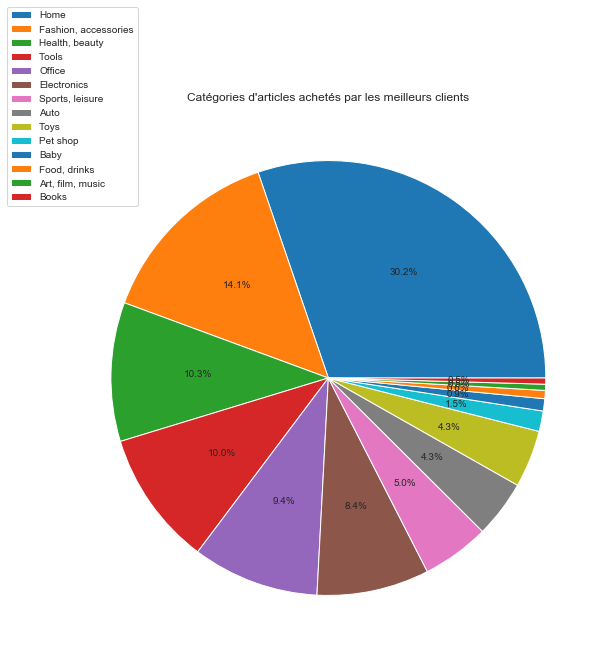

In [48]:
fig = plt.figure(figsize=(10, 10))

plt.title("Catégories d'articles achetés par les meilleurs clients")
plt.pie(tableau_meilleur['Effectif'], autopct='%1.1f%%')
plt.legend(tableau_meilleur.index, loc='center left',
           bbox_to_anchor=(-0.1, 1.))

Pourcentage de clients en provenance d'une grande ville

In [49]:
# The best clients
round(sum(meilleurs['city_sup_1m'])*100/meilleurs.shape[0], 2)

29.33

In [50]:
# All clients
round(sum(data_RFM['city_sup_1m'])*100/data.shape[0], 2)

35.57

Review score

In [51]:
meilleurs['review_score_mean_per_order'].describe()

count    208.000000
mean       4.160967
std        1.051400
min        1.000000
25%        3.500000
50%        4.500000
75%        5.000000
max        5.000000
Name: review_score_mean_per_order, dtype: float64

Valeur moyenne de la commande

In [52]:
meilleurs['order_value_mean'].describe()

count     208.000000
mean      322.006321
std       201.015459
min       177.365000
25%       207.685750
50%       249.455000
75%       352.480000
max      1697.287143
Name: order_value_mean, dtype: float64

Type de paiement

In [53]:
liste_paiement = ['num_payment_type_credit_card', 'num_payment_type_voucher',
                  'num_payment_type_boleto', 'num_payment_type_debit_card']

In [54]:
index_paiement = ['Credit card', 'Voucher', 'Boleto', 'Debit card']

In [55]:
tableau_meilleur_paiement = fonctions.tableau_effectif(
    meilleurs, liste_paiement, index_paiement)

In [56]:
tableau_meilleur_paiement

,Effectif,Pourcentage
Credit card,496.0,71.57
Boleto,156.0,22.51
Voucher,31.0,4.47
Debit card,10.0,1.44


Etat 

In [57]:
liste_state = ['state_SP', 'state_RJ',
               'state_MG', 'state_RS', 'state_PR', 'state_SC', 'state_BA', 'state_other']

In [58]:
index_state = ['Sao Paulo', 'Rio de Janeiro', 'Minas Gerais', 'Rio Grande do Sul',
               'Parana', 'Santa Catarina', 'Bahia', 'Other']

In [59]:
tableau_meilleur_state = fonctions.tableau_effectif(meilleurs, liste_state, index_state)

In [60]:
tableau_meilleur_state

,Effectif,Pourcentage
Sao Paulo,81,38.94
Other,32,15.38
Rio de Janeiro,31,14.90
Minas Gerais,23,11.06
Rio Grande do Sul,13,6.25
Parana,11,5.29
Santa Catarina,11,5.29
Bahia,6,2.88


#### Caractéristiques nouveaux clients

In [61]:
nouveau = data_RFM[data_RFM['RFM_nouveau'] == 1]

In [62]:
nouveau.shape

(23053, 76)

In [63]:
tableau_nouveau = fonctions.tableau_effectif(nouveau, liste_categories, index)

In [64]:
tableau_nouveau

,Effectif,Pourcentage
Home,6708,26.03
"Health, beauty",3710,14.40
Office,2423,9.40
Electronics,2414,9.37
"Fashion, accessories",2354,9.14
Tools,1739,6.75
"Sports, leisure",1649,6.40
Auto,1213,4.71
Toys,1137,4.41
Baby,823,3.19


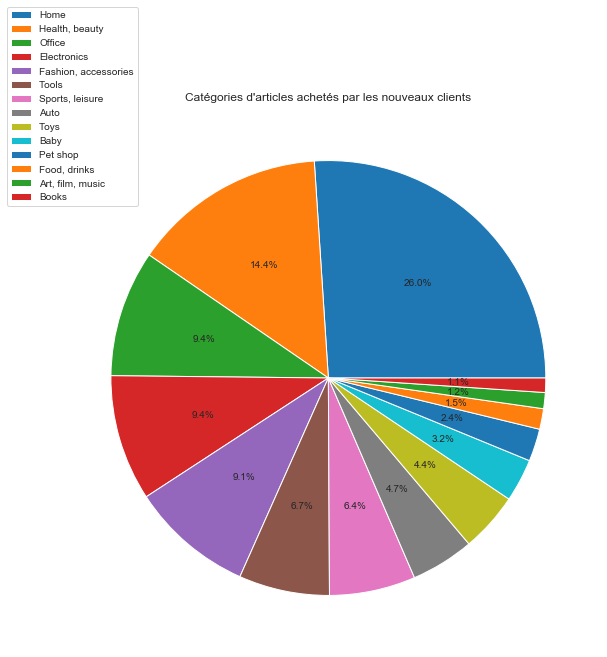

In [65]:
fig = plt.figure(figsize=(10, 10))

plt.title("Catégories d'articles achetés par les nouveaux clients")
plt.pie(tableau_nouveau['Effectif'], autopct='%1.1f%%')
plt.legend(tableau_nouveau.index, loc='center left', bbox_to_anchor=(-0.1, 1.))

Pourcentage de clients en provenance d'une grande ville

In [66]:
# The best clients
round(sum(nouveau['city_sup_1m'])*100/nouveau.shape[0], 2)

37.67

Review score

In [67]:
nouveau['review_score_mean_per_order'].describe()

count    23053.000000
mean         4.240966
std          1.235833
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_score_mean_per_order, dtype: float64

Valeur moyenne de la commande

In [68]:
nouveau['order_value_mean'].describe()

count    23053.000000
mean       165.366132
std        238.717256
min          9.590000
25%         62.540000
50%        107.850000
75%        179.000000
max       7274.880000
Name: order_value_mean, dtype: float64

Type de paiement

In [69]:
tableau_nouveau_paiements = fonctions.tableau_effectif(
    nouveau, liste_paiement, index_paiement)

In [70]:
tableau_nouveau_paiements

,Effectif,Pourcentage
Credit card,20308.0,74.93
Boleto,4864.0,17.95
Voucher,1157.0,4.27
Debit card,774.0,2.86


Etat 

In [71]:
tableau_nouveau_state = fonctions.tableau_effectif(nouveau, liste_state, index_state)

In [72]:
tableau_nouveau_state

,Effectif,Pourcentage
Sao Paulo,10738,46.58
Other,3355,14.55
Rio de Janeiro,2658,11.53
Minas Gerais,2551,11.07
Parana,1140,4.95
Rio Grande do Sul,1118,4.85
Santa Catarina,748,3.24
Bahia,745,3.23


#### Comparaison de nouvaux et de meilleurs clients

Catégories de produits

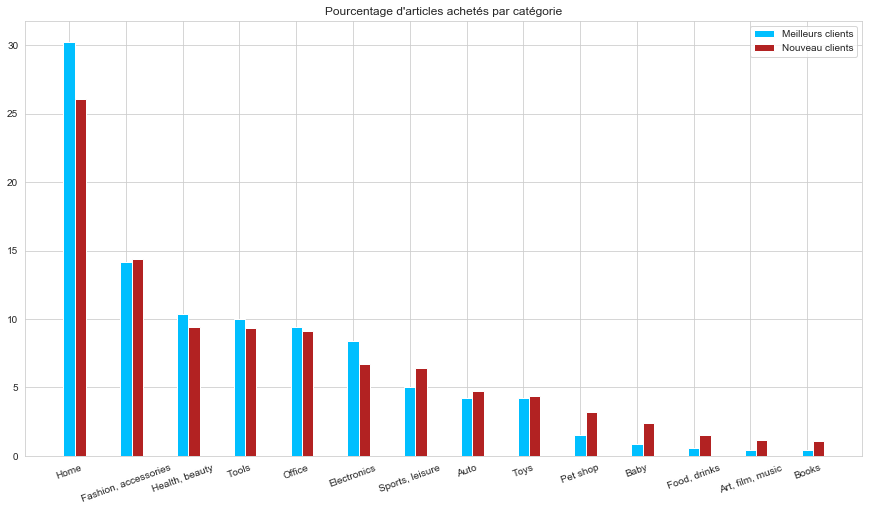

In [73]:
fig = plt.figure(figsize=(15, 8))

# set width of bar
barWidth = 0.2

# set height of bar
bars1 = tableau_meilleur['Pourcentage']
bars2 = tableau_nouveau['Pourcentage']

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1, bars1, color='deepskyblue', width=barWidth,
        edgecolor='white', label='Meilleurs clients')
plt.bar(r2, bars2, color='firebrick', width=barWidth,
        edgecolor='white', label='Nouveau clients')

# Define title
plt.title("Pourcentage d'articles achetés par catégorie")

# Add xticks on the middle of the group bars
plt.xticks(range(tableau_meilleur.shape[0]),
           tableau_meilleur.index,  rotation=20)

# Create legend & Show graphic
plt.legend()
plt.show()

Mode de paiement

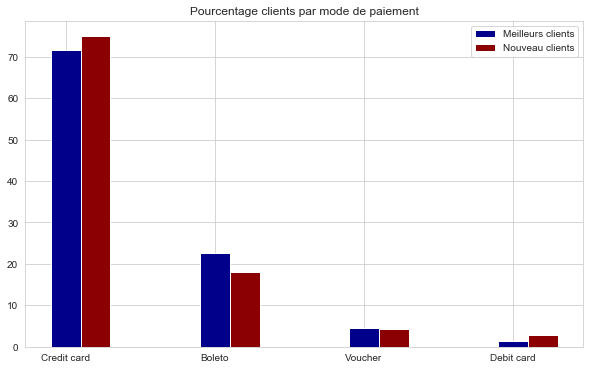

In [74]:
fig = plt.figure(figsize=(10, 6))

# set width of bar
barWidth = 0.2

# set height of bar
bars1 = tableau_meilleur_paiement['Pourcentage']
bars2 = tableau_nouveau_paiements['Pourcentage']

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1, bars1, color='darkblue', width=barWidth,
        edgecolor='white', label='Meilleurs clients')
plt.bar(r2, bars2, color='darkred', width=barWidth,
        edgecolor='white', label='Nouveau clients')

# Define title
plt.title("Pourcentage clients par mode de paiement")

# Add xticks on the middle of the group bars
plt.xticks(
    range(tableau_meilleur_paiement.shape[0]), tableau_meilleur_paiement.index)

# Create legend & Show graphic
plt.legend()
plt.show()

Etat

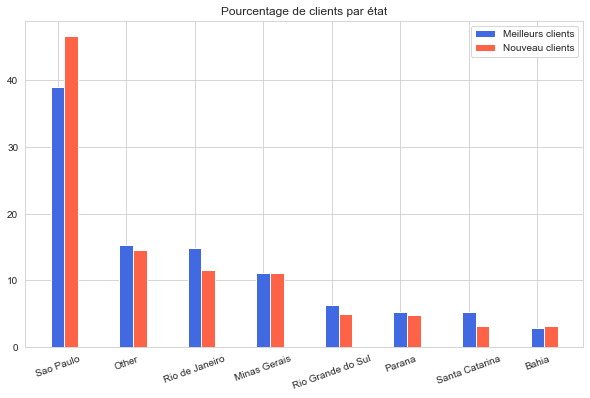

In [75]:
fig = plt.figure(figsize=(10, 6))

# set width of bar
barWidth = 0.2

# set height of bar
bars1 = tableau_meilleur_state['Pourcentage']
bars2 = tableau_nouveau_state['Pourcentage']

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1, bars1, color='royalblue', width=barWidth,
        edgecolor='white', label='Meilleurs clients')
plt.bar(r2, bars2, color='tomato', width=barWidth,
        edgecolor='white', label='Nouveau clients')

# Define title
plt.title("Pourcentage de clients par état")

# Add xticks on the middle of the group bars
plt.xticks(range(
    tableau_meilleur_state.shape[0]), tableau_meilleur_state.index, rotation=20)

# Create legend & Show graphic
plt.legend()
plt.show()

# 6 - Réduction dimensionnelle

## 6.1 Analyse en composantes principales

### 6.1.1 Préparation de données

In [76]:
data_analyses = data.rename(index=data['customer_unique_id'])

In [77]:
data_analyses.drop(['state_other', 'category_other', 'customer_unique_id', 'order_purchase_timestamp_min',
                    'order_purchase_timestamp_max', 'order_purchase_timestamp_max_dt',
                    'order_purchase_timestamp_min_dt'], axis=1, inplace=True)

In [78]:
data_analyses.shape

(95420, 57)

In [79]:
# As we do not have any payment information for one individual, we will exclude it from the analysis :
data_analyses.dropna(inplace=True)

In [80]:
data_analyses.shape

(95419, 57)

In [81]:
data_analyses.head()

,delay_last_order,delay_first_order,num_reviews_mean,review_score_mean_per_order,num_comment_title_mean,num_comment_message_mean,review_delay_min_days,review_delay_max_days,num_payment_type_credit_card,num_payment_type_voucher,...,payment_type_debit_card_mean,num_products_per_order_mean,city_sup_1m,state_SP,state_RJ,state_MG,state_RS,state_PR,state_SC,state_BA
861eff4711a542e4b93843c6dd7febb0,894,894,1.0,4.0,0.0,0.0,4,4,1.0,0.0,...,0.0,1.0,0,1,0,0,0,0,0,0
290c77bc529b7ac935b93aa66c333dc3,653,653,1.0,5.0,0.0,0.0,11,11,1.0,0.0,...,0.0,1.0,0,1,0,0,0,0,0,0
060e732b5b29e8181a18229c7b0b2b5e,526,526,1.0,5.0,0.0,0.0,0,0,1.0,0.0,...,0.0,1.0,1,1,0,0,0,0,0,0
259dac757896d24d7702b9acbbff3f3c,593,593,1.0,5.0,0.0,0.0,4,4,1.0,0.0,...,0.0,1.0,0,1,0,0,0,0,0,0
345ecd01c38d18a9036ed96c73b8d066,455,455,1.0,5.0,1.0,1.0,7,7,1.0,0.0,...,0.0,1.0,1,1,0,0,0,0,0,0


Nous allons utiliser ACP afin de réduire la dimension de données pour pouvoir les visualiser. 

Dans un premier temps, nous allons standardiser les données.

In [82]:
data_std = StandardScaler().fit_transform(data_analyses)

In [83]:
type(data_std)

numpy.ndarray

In [84]:
data_std.shape

(95419, 57)

### 6.1.2 Analyse en 2 components principals

Le code suivant nous permet de transformer les données en 2 components principales.

In [85]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data_std)
principalDf = pd.DataFrame(data=principalComponents, columns=[
                           'principal component 1', 'principal component 2'])

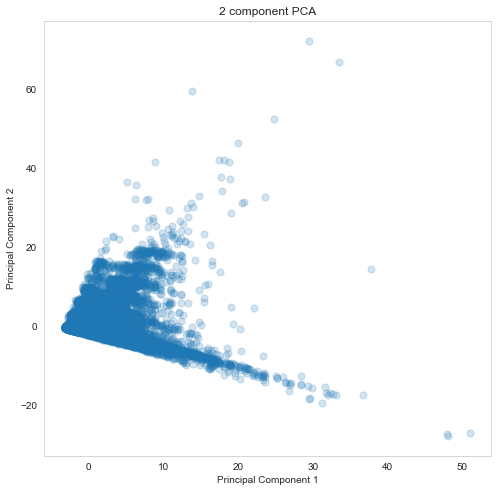

In [86]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize=10)
ax.set_ylabel('Principal Component 2', fontsize=10)
ax.set_title('2 component PCA', fontsize=12)

ax.scatter(principalDf['principal component 1'],
           principalDf['principal component 2'], s=50, alpha=0.2)
ax.grid()

In [87]:
sum(pca.explained_variance_ratio_)

0.19423888240152518

In [88]:
pca.explained_variance_ratio_

array([0.10294454, 0.09129434])

Regarder contribution de chaque variable aux composantes principales:

(-0.7, 0.7)

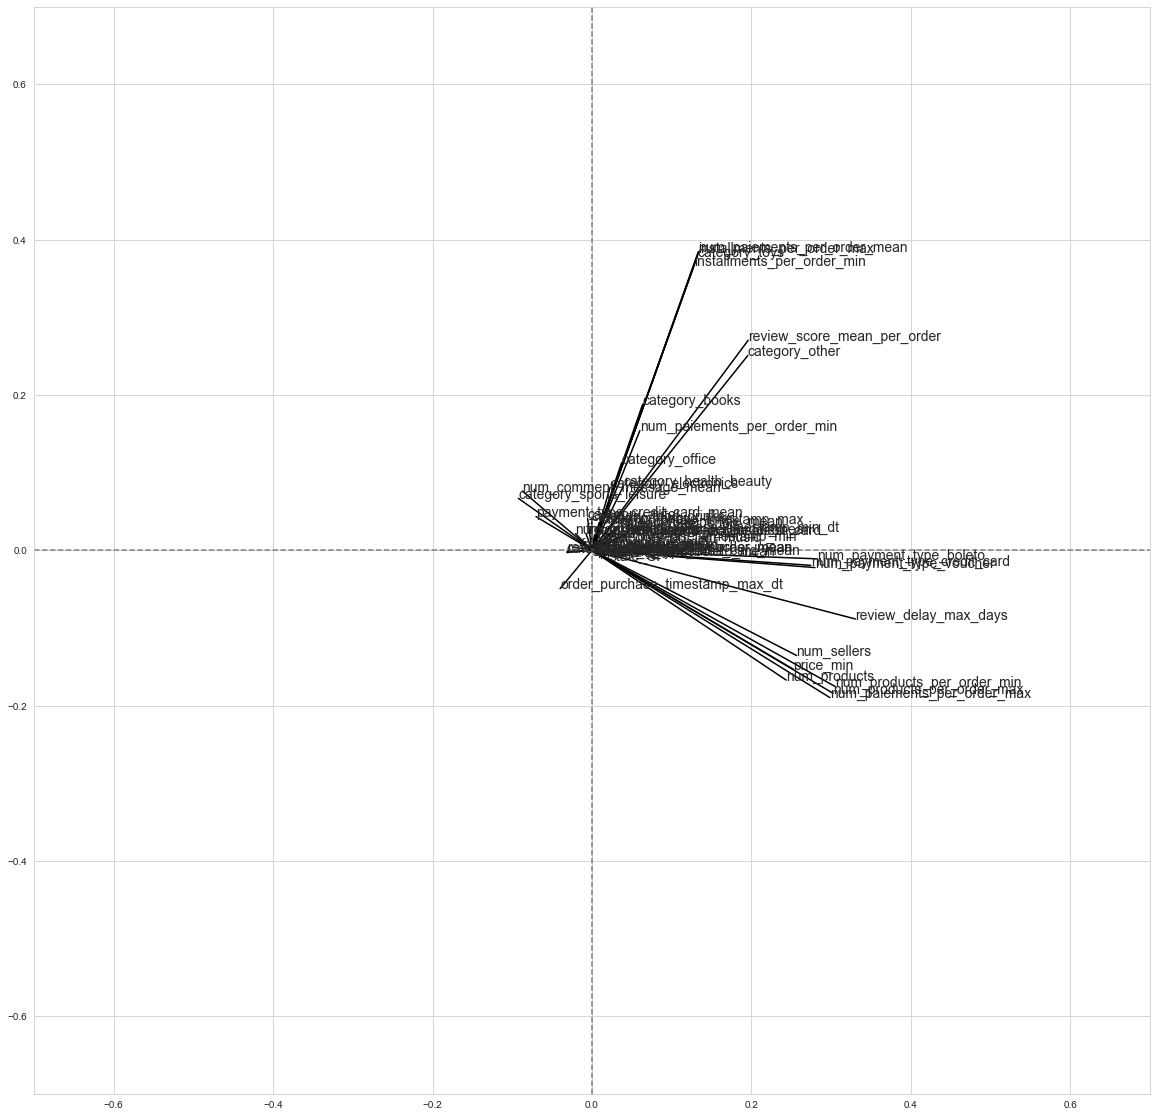

In [89]:
pcs = pca.components_

fig = plt.figure(figsize=(20, 20))

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, data.columns[i], fontsize='14')

# Afficher une ligne horizontale y=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')

plt.xlim([-0.7, 0.7])
plt.ylim([-0.7, 0.7])

### 6.1.3 Analyse en 3 components principales

In [90]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(data_std)
principalDf = pd.DataFrame(data=principalComponents, columns=[
                           'principal component 1', 'principal component 2', 'principal component 3'])

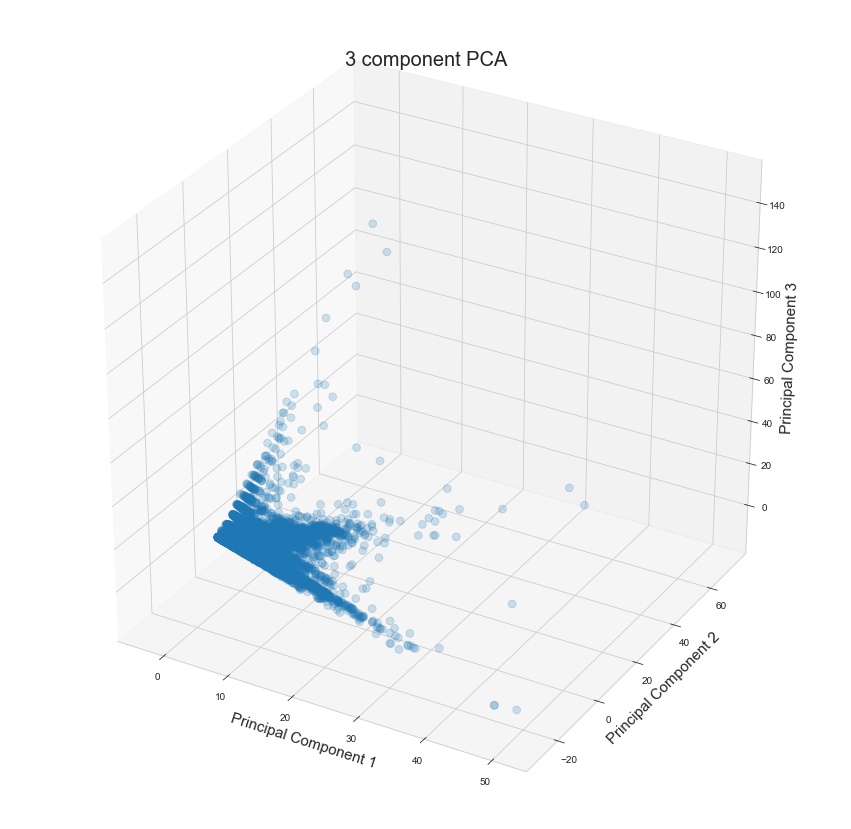

In [91]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize=15)
ax.set_ylabel('Principal Component 2', fontsize=15)
ax.set_zlabel('Principal Component 3', fontsize=15)
ax.set_title('3 component PCA', fontsize=20)

ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'],
           principalDf['principal component 3'], s=60, alpha=0.2)
ax.grid()

Variance expliquée par le modèle :

In [92]:
sum(pca.explained_variance_ratio_)

0.27656724028911156

### 6.1.4 Obtenir un nombre de CP optimal

L'ACP avec deux components principales n'explique qu'une patite partie de variance de modèle. Nous allons étudier combien de components faut-il inclure pour obtenir une variance expliquée raisonnable :

In [93]:
pca = PCA()
pca.fit(data_std)
cumsum = np.cumsum(pca.explained_variance_ratio_)

In [94]:
cumsum.shape

(57,)

In [95]:
data_std.shape

(95419, 57)

<Figure size 432x288 with 0 Axes>

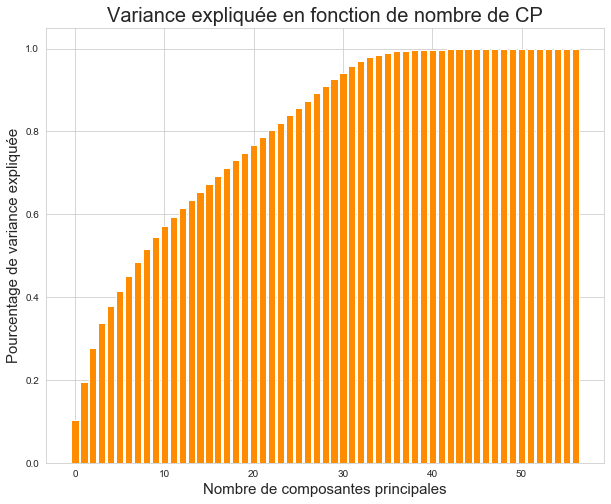

In [96]:
plt.figure()
fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(111)
ax.set_xlabel('Nombre de composantes principales', fontsize=15)
ax.set_ylabel('Pourcentage de variance expliquée', fontsize=15)
ax.set_title('Variance expliquée en fonction de nombre de CP', fontsize=20)

plt.bar(range(data_std.shape[1]), cumsum, color='darkorange')

plt.show()

In [97]:
names = []
for i in range(1, 31):
    elt = 'PC' + str(i)
    names.append(elt)

Si nous utilisons la règle du "coude", nous allons garder 30 composantes principales qui expliquerait plus que 90% de la variance totale.

In [98]:
pca_final = PCA(n_components=30)
principalComponents_final = pca_final.fit_transform(data_std)
data_ACP_30CP = pd.DataFrame(
    data=principalComponents_final, columns=names, index=data_analyses.index)

In [99]:
data_ACP_30CP.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
861eff4711a542e4b93843c6dd7febb0,-0.393204,-0.403101,-0.126299,-0.334207,-1.645600,0.190624,0.333809,-0.294729,-0.596775,1.271320,...,-0.403139,-0.107527,-0.070205,-0.042996,0.273371,-0.459559,-0.027521,0.210837,0.325895,-0.261162
290c77bc529b7ac935b93aa66c333dc3,3.677567,-1.725261,-0.362475,-0.836104,-0.279764,-0.681794,0.921672,0.486310,0.110868,-1.083140,...,0.187919,0.149668,-0.171277,-0.062598,-0.023738,-0.120593,-0.345470,0.031757,0.116073,0.090446
060e732b5b29e8181a18229c7b0b2b5e,0.947733,-0.456169,-0.159573,-1.748498,0.761240,0.869725,-0.712773,0.566096,0.036314,-1.117965,...,-0.457884,0.570140,-0.190588,0.012032,0.078698,-0.200007,-0.073003,0.157231,-0.041417,-0.309677
259dac757896d24d7702b9acbbff3f3c,-0.521711,-0.572137,-0.245993,0.147178,0.635921,0.070673,0.001478,0.512720,-0.056556,1.520403,...,-0.343414,-0.030213,-0.161076,-0.144356,0.122362,-0.409260,-0.138275,0.217468,0.049651,-0.373291
345ecd01c38d18a9036ed96c73b8d066,2.207662,-0.746979,-0.281909,-1.676835,2.273367,0.637202,-0.027306,1.775726,0.949444,-2.304092,...,-0.360100,0.396271,-0.258398,-0.274627,0.083698,-0.077730,-0.170799,-0.088773,0.002637,-0.282857


In [100]:
sum(pca_final.explained_variance_ratio_)

0.9264201406009764

En réduisant le nombre de dimensions de 50 à 30, nous gardons 92% de variance expliquée par le modèle.

## 6.2 Analyse en composantes principales à noyau

### 6.2.1 Echantillonnage de données

Afin de pouvoir utiliser les techniques qui sont assez exigeantes au niveau de temps de calcul, nous allons travailler sur un échantillon aléatoire de 10% de données :

In [101]:
n = int(data_std.shape[0]/10)

In [102]:
data_sample = DataFrame(data_std).sample(n, random_state=1)

In [103]:
data_sample.head()

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
40722,-1.381583,-1.394586,-0.064382,0.681944,2.739179,-0.846100,-0.159107,-0.163570,0.125004,-0.117305,...,-0.115949,-0.263988,1.345730,-0.848897,2.599547,-0.36423,-0.241248,-0.231158,-0.195394,-0.187989
74007,0.877602,0.857302,-0.064382,0.681944,-0.367533,-0.846100,-0.159107,-0.163570,0.125004,-0.117305,...,-0.115949,-0.263988,-0.743091,-0.848897,-0.384682,-0.36423,-0.241248,4.326045,-0.195394,-0.187989
2015,0.159364,0.141384,-0.064382,-0.065011,-0.367533,1.182317,-0.159107,-0.163570,0.125004,-0.117305,...,-0.115949,-0.263988,-0.743091,-0.848897,-0.384682,-0.36423,-0.241248,-0.231158,-0.195394,-0.187989
76605,-0.251990,-0.268642,-0.064382,-0.065011,-0.367533,-0.846100,-0.262270,-0.264763,0.125004,-0.117305,...,-0.115949,-0.263988,-0.743091,-0.848897,-0.384682,-0.36423,-0.241248,-0.231158,-0.195394,-0.187989
16824,0.368306,0.349651,-0.064382,0.681944,-0.367533,1.182317,-0.159107,-0.163570,0.125004,-0.117305,...,-0.115949,-0.263988,1.345730,1.178000,-0.384682,-0.36423,-0.241248,-0.231158,-0.195394,-0.187989


In [104]:
data_sample.shape

(9541, 57)

### 6.2.2 Visualisation de données 

#### Kernel poly

In [105]:
# Sample
kpca = KernelPCA(n_components=2, kernel='poly', degree=2, n_jobs=-1)
data_kpca = kpca.fit_transform(data_sample)

In [106]:
principalDf = pd.DataFrame(data=data_kpca, columns=[
                           'principal component 1', 'principal component 2'])

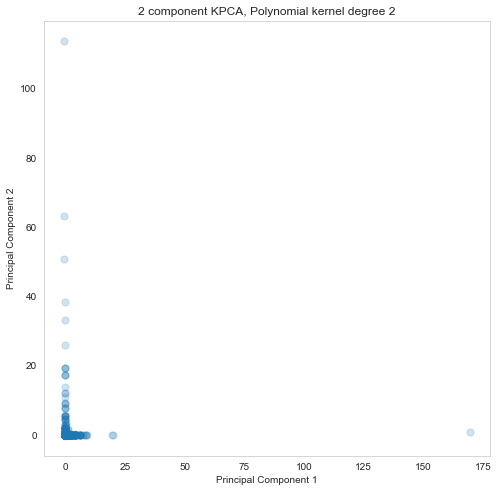

In [107]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize=10)
ax.set_ylabel('Principal Component 2', fontsize=10)
ax.set_title('2 component KPCA, Polynomial kernel degree 2', fontsize=12)

ax.scatter(principalDf['principal component 1'],
           principalDf['principal component 2'], s=50, alpha=0.2)
ax.grid()

#### Kernel Gaussien

In [108]:
# Sample
kpca = KernelPCA(n_components=2, kernel='rbf')
data_kpca = kpca.fit_transform(data_sample)

In [109]:
principalDf = pd.DataFrame(data=data_kpca, columns=[
                           'principal component 1', 'principal component 2'])

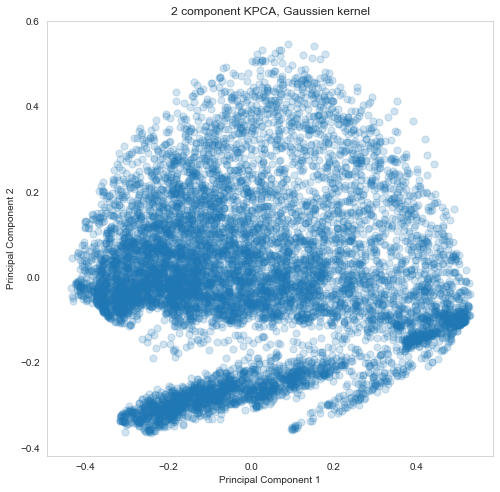

In [110]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize=10)
ax.set_ylabel('Principal Component 2', fontsize=10)
ax.set_title('2 component KPCA, Gaussien kernel', fontsize=12)

ax.scatter(principalDf['principal component 1'],
           principalDf['principal component 2'], s=50, alpha=0.2)
ax.grid()

In [111]:
kpca = KernelPCA(n_components=3, kernel='rbf')
principalComponents = kpca.fit_transform(data_sample)
principalDf = pd.DataFrame(data=principalComponents, columns=[
                           'principal component 1', 'principal component 2', 'principal component 3'])

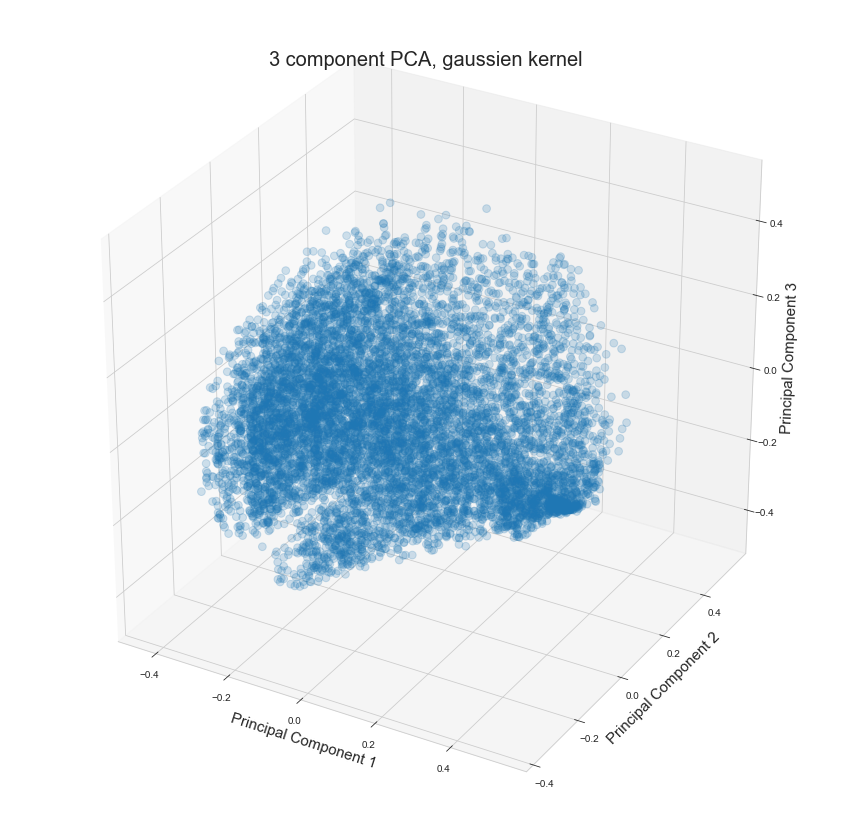

In [112]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize=15)
ax.set_ylabel('Principal Component 2', fontsize=15)
ax.set_zlabel('Principal Component 3', fontsize=15)
ax.set_title('3 component PCA, gaussien kernel', fontsize=20)

ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'],
           principalDf['principal component 3'], s=60, alpha=0.2)
ax.grid()

## 6.3 Isomap

In [113]:
isomap = Isomap(n_components=2)
data_iso = isomap.fit_transform(data_sample)

In [114]:
isomapDf = pd.DataFrame(data=data_iso, columns=[
                        'principal component 1', 'principal component 2'])

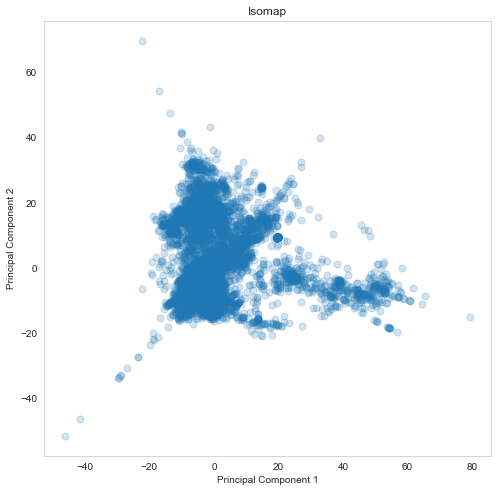

In [115]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize=10)
ax.set_ylabel('Principal Component 2', fontsize=10)
ax.set_title('Isomap', fontsize=12)

ax.scatter(isomapDf['principal component 1'],
           isomapDf['principal component 2'], s=50, alpha=0.2)
ax.grid()

# 7 - Clustering

## 7.1 Clustering hiérarchique

Nous allons créer un clustering hiérarchique sur l'échantillon de données afin d'avoir une idée sur le nombre de clusters à faire à l'aide de l'algorithme k-means. Etant donné que nous allons travailler sur le jeu de données avec une réduction dimensionnelle (APC avec 30 composantes principales), nous allons faire la même transformation sur notre échantillon de données :

In [116]:
principalComponentsSample = pca_final.fit_transform(data_sample)
data_ACP_30CP_sample = pd.DataFrame(
    data=principalComponentsSample, columns=names)

In [117]:
sum(pca_final.explained_variance_ratio_)

0.9313220902128673

### 7.1.1 Distance euclidienne 

In [118]:
fusions = linkage(data_ACP_30CP_sample, method='complete', metric='euclidean')

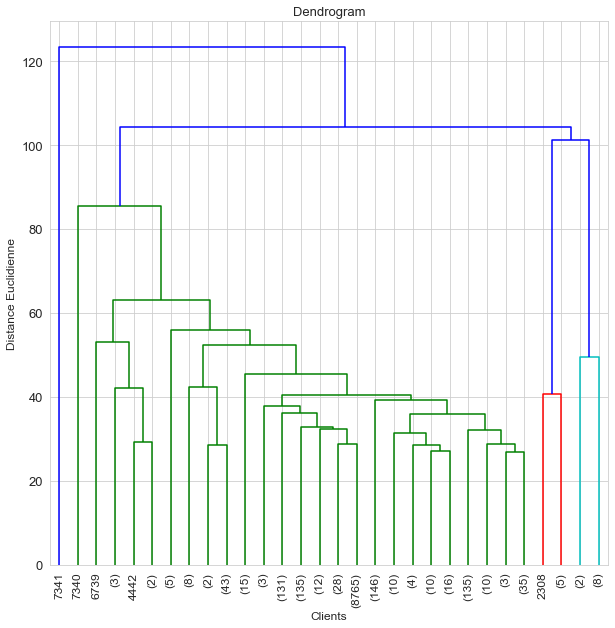

In [119]:
fig = plt.figure(figsize=(10, 10))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_xlabel('Clients', fontsize=12)
ax.set_ylabel('Distance Euclidienne', fontsize=12)
ax.set_title('Dendrogram', fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=13)


dendrogram(fusions,
           leaf_rotation=90,
           leaf_font_size=12,
           truncate_mode='lastp', 
           show_leaf_counts=True
           )

plt.show()

### 7.1.2 Distance de Mahalanobis

In [120]:
fusions = linkage(data_ACP_30CP_sample,
                  method='complete', metric='mahalanobis')

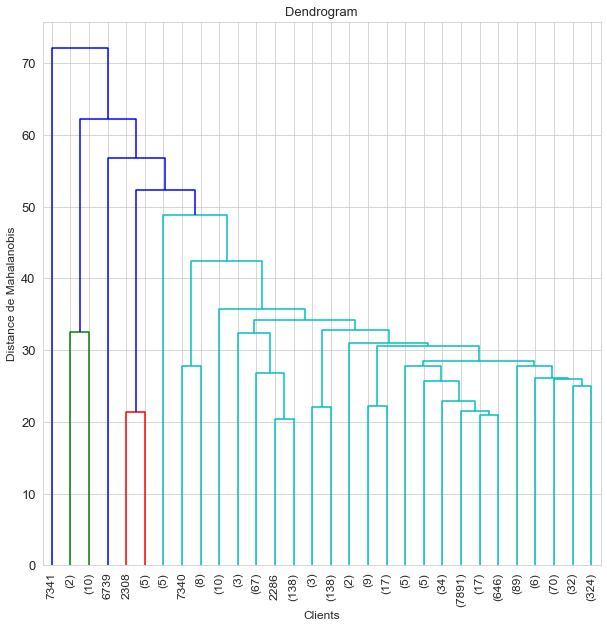

In [121]:
fig = plt.figure(figsize=(10, 10))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_xlabel('Clients', fontsize=12)
ax.set_ylabel('Distance de Mahalanobis', fontsize=12)
ax.set_title('Dendrogram', fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=13)


dendrogram(fusions,
           leaf_rotation=90,
           leaf_font_size=12,
           truncate_mode='lastp'
           )

plt.show()

### 7.1.3 Distance Cityblock

In [122]:
fusions = linkage(data_ACP_30CP_sample, method='complete', metric='cityblock')

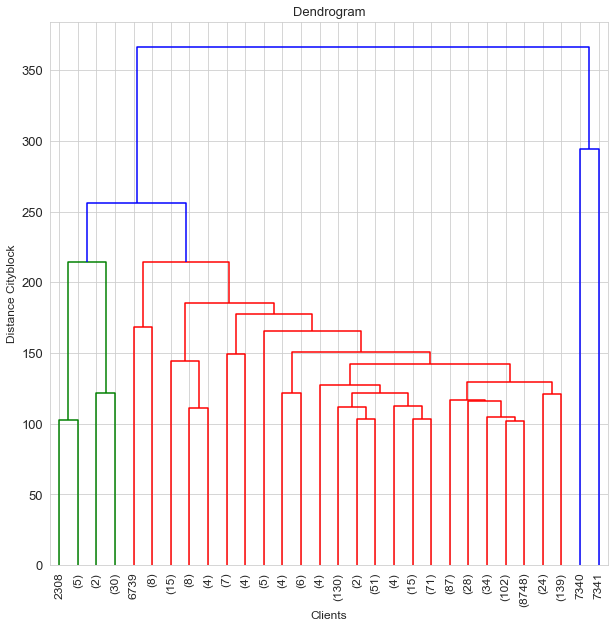

In [123]:
fig = plt.figure(figsize=(10, 10))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_xlabel('Clients', fontsize=12)
ax.set_ylabel('Distance Cityblock', fontsize=12)
ax.set_title('Dendrogram', fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=13)


dendrogram(fusions,
           leaf_rotation=90,
           leaf_font_size=12,
           truncate_mode='lastp'
           )

plt.show()

Aucune des trois techniques ne donne des résultats satisfaisants : selon la visualisation de dendrogramme, nous ne pouvons pas définir clairement le nombre de segments.

## 7.2 k-means

### 7.2.1 Ajuster un modèle pour 3 clusters

Nous allons tout d'abord performer l'algorithme k-means sur notre échantillons de donnés afin de rechercher le nombre de clusters optimal :

In [124]:
k = 3

In [125]:
kmeans = KMeans(n_clusters=k, random_state = 1)

In [126]:
y_pred = kmeans.fit_predict(data_ACP_30CP_sample)

Vecteur de classes :

In [127]:
y_pred

array([2, 0, 0, ..., 2, 2, 2])

Les 3 centroïdes :

In [128]:
kmeans.cluster_centers_

array([[ 3.62078416e+00,  1.44972511e-01, -1.46732017e-01,
        -7.06955349e-01,  1.47435540e-01, -1.28238521e-01,
        -1.77124494e-01, -4.68979876e-01, -4.88642589e-01,
         3.76945251e-01,  5.51416154e-02, -8.69736965e-02,
         7.95799927e-02,  4.24426623e-02,  3.58347987e-02,
         4.64050765e-02,  1.35868836e-01,  3.19324697e-02,
        -5.58188774e-02,  1.75283572e-02,  3.28281858e-02,
         2.35010248e-02,  2.91650199e-02, -1.56632103e-02,
         5.80208761e-02,  1.75502928e-02, -1.53729975e-02,
         1.60669097e-02,  2.06192028e-02, -1.17128843e-02],
       [ 1.18056177e+00, -1.12442574e-01,  2.82945899e+01,
         3.31636111e+00, -1.60154155e+00,  4.54493289e-01,
         3.41447097e-01,  2.89098811e-01, -7.27685323e-01,
         1.80901247e-01,  5.18735622e-02, -1.53310009e-01,
         1.24834740e-01,  1.35227536e-01, -2.18490939e-01,
         9.18022364e-02,  4.07492403e-02,  1.09493954e-01,
        -7.13569810e-02,  4.91383879e-02,  1.29417388e-

Coefficient de silhouette :

In [129]:
silhouette_score(data_ACP_30CP_sample, kmeans.labels_)

0.22369652244994864

Visualisation de clusters :

In [130]:
y_pred = DataFrame(y_pred)

In [131]:
y_pred.rename({0: 'Cluster'}, axis=1, inplace=True)

In [132]:
data_ACP_30CP_sample = data_ACP_30CP_sample.merge(
    y_pred, left_index=True, right_index=True)

In [133]:
# Sample
kpca = KernelPCA(n_components=2, kernel='rbf')
data_kpca = kpca.fit_transform(data_ACP_30CP_sample)

In [134]:
principalDf = pd.DataFrame(data=data_kpca, columns=[
                           'principal component 1', 'principal component 2'])

In [135]:
principalDf = principalDf.merge(y_pred, left_index=True, right_index=True)

In [136]:
principalDf.head()

,principal component 1,principal component 2,Cluster
0,0.041330,0.167121,2
1,-0.367671,-0.022323,0
2,-0.202619,0.535128,0
3,-0.033710,0.003607,2
4,0.419962,-0.016299,2


In [137]:
principalDf.columns

Index(['principal component 1', 'principal component 2', 'Cluster'], dtype='object')

In [138]:
type(principalDf['Cluster'][0])

numpy.int32

In [139]:
principalDf['Cluster'].value_counts()

2    7641
0    1868
1      32
Name: Cluster, dtype: int64

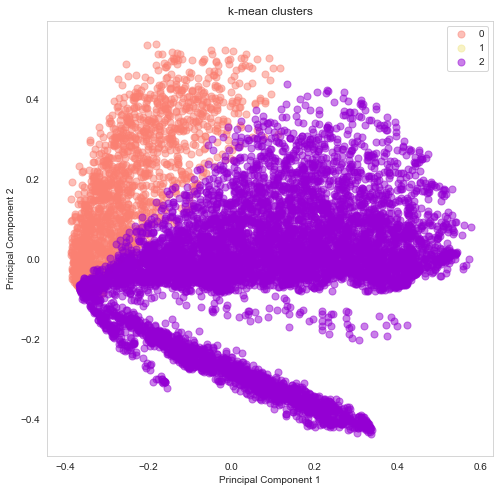

In [140]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize=10)
ax.set_ylabel('Principal Component 2', fontsize=10)
ax.set_title('k-mean clusters', fontsize=12)

targets = [0, 1, 2]
colors = ['salmon', 'khaki', 'darkviolet']
for target, color in zip(targets, colors):
    indicesToKeep = principalDf['Cluster'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1'],
               principalDf.loc[indicesToKeep, 'principal component 2'], c=color, s=50, alpha=0.5)
ax.legend(targets)
ax.grid()

Avec Isomap :

In [141]:
isomap = Isomap(n_components=2)
data_iso = isomap.fit_transform(data_sample)

In [142]:
isomapDf = pd.DataFrame(data=data_iso, columns=[
                        'principal component 1', 'principal component 2'])

In [143]:
principalDf = pd.DataFrame(data=isomapDf, columns=[
                           'principal component 1', 'principal component 2'])

In [144]:
principalDf = principalDf.merge(y_pred, left_index=True, right_index=True)

In [145]:
principalDf.head()

,principal component 1,principal component 2,Cluster
0,-2.306824,-4.120825,2
1,13.883632,-1.667643,0
2,-4.187374,-2.828672,0
3,-3.061151,-6.469800,2
4,5.744972,-8.403080,2


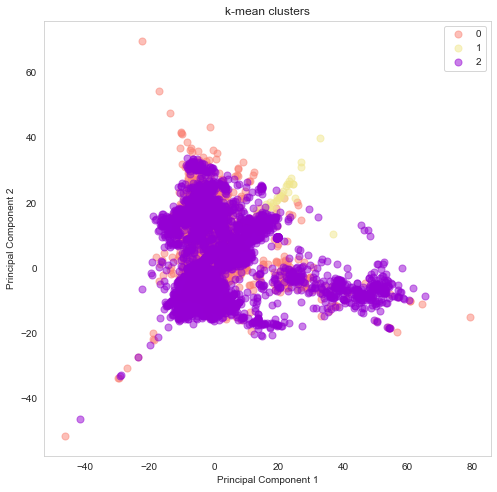

In [146]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize=10)
ax.set_ylabel('Principal Component 2', fontsize=10)
ax.set_title('k-mean clusters', fontsize=12)

targets = [0, 1, 2]
colors = ['salmon', 'khaki', 'darkviolet']
for target, color in zip(targets, colors):
    indicesToKeep = principalDf['Cluster'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1'],
               principalDf.loc[indicesToKeep, 'principal component 2'], c=color, s=50, alpha=0.5)
ax.legend(targets)
ax.grid()

### 7.2.2 Recherce de nombre de clusters optimal à l'aide de coefficient de silhouette

In [147]:
silhouette = []

In [148]:
k = list(range(2, 9))

In [149]:
for i in k:
    kmeans = KMeans(n_clusters=i, random_state=3)
    y_pred = kmeans.fit_predict(data_ACP_30CP_sample)
    score = silhouette_score(data_ACP_30CP_sample, kmeans.labels_)
    silhouette.append(score)

In [150]:
silhouette

[0.24206124443802501,
 0.23843021798299027,
 0.21189559777701306,
 0.10614362281648038,
 0.10190095598325527,
 0.10034262941882366,
 0.07546489975404447]

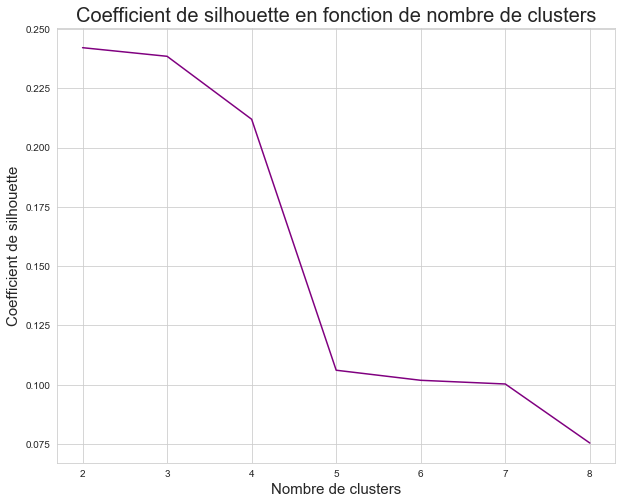

In [151]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Nombre de clusters', fontsize=15)
ax.set_ylabel('Coefficient de silhouette', fontsize=15)
ax.set_title(
    'Coefficient de silhouette en fonction de nombre de clusters', fontsize=20)

plt.plot(k, silhouette, color="purple")

Le coefficient de silhouette maximal est atteint avec une segmentation en deux clusters. Etant donné qu'une segmentation en trois clusters peut être plus intéressant au niveau commercial et que le coefficient ne varie pas beaucoup entre segmentation en deux ou trois clusters, nous allons choisir trois clusters et nous allons appliquer l'algorithme sur le jeu de données complet :

### 7.2.3 Modèle optimal appliqué sur le jeu de données complet 

Nous allons appliquer le modèle sur le jeu de données complet :

In [152]:
kmeans = KMeans(n_clusters=3, random_state=3)

In [153]:
y_pred = kmeans.fit_predict(data_ACP_30CP)

Ensuite nous allons ajouter les clusters créés au jeu de donné complet afin de pouvoir reconstituer les données et décrire les clusters.

In [154]:
y_pred = DataFrame(y_pred, index=data_analyses.index)

In [155]:
y_pred.rename({0: 'Cluster'}, axis=1, inplace=True)

Pour avoir une idée sur l'effectif de chaque cluster:

In [156]:
effectif_clusters_k_means = DataFrame(y_pred['Cluster'].value_counts())
effectif_clusters_k_means

,Cluster
0,72489
2,13724
1,9206


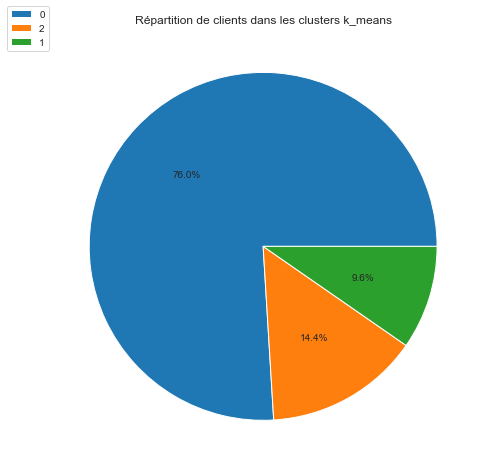

In [157]:
fig = plt.figure(figsize=(8, 8))

plt.title('Répartition de clients dans les clusters k_means')
plt.pie(effectif_clusters_k_means['Cluster'], autopct='%1.1f%%')
plt.legend(effectif_clusters_k_means.index,
           loc='center left', bbox_to_anchor=(-0.1, 1.))

### 7.2.4 Evaluation de clusters

Afin d'évaluer le résultat de segmentation, nous allons calculer l'indice de Davies-Bouldin, qui compare les distances intra-cluster aux distances inter-cluster. 

In [158]:
davies_bouldin_score(data_ACP_30CP, kmeans.labels_)

2.3538547357255717

Nous allons aussi utiliser un modèle supervisé afin de voir si nous pouvons prédire correctement les clusters construits avec k-means. Nous allons construire le modèle arbre de décision afin de voir:
1. Quels sont les features les plus importantes pour la construction de l'arbre
2. Avec quelle précision le modèle prédit les clusters sur les données test

Etant donné que les arbres de décision fonctionnent bien sur les données qui ne sont pas standardisées, nous allons utiliser le jeu de données avant la standardisation : data_analyses


In [159]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    data_analyses, y_pred, test_size=0.3, random_state=1)

In [160]:
arbre = DecisionTreeClassifier(max_depth=6, random_state=3)

In [161]:
arbre = arbre.fit(X_train, y_train)

Importance de features

In [168]:
feature_importances = DataFrame(arbre.feature_importances_, index = data_analyses.columns)

In [169]:
feature_importances.rename({0:'Feature importance'}, axis=1, inplace=True)

In [170]:
feature_importances.sort_values(['Feature importance'], ascending=False, inplace=True)

In [171]:
feature_importances

,Feature importance
installments_per_order_min,0.371039
num_payment_type_credit_card,0.360080
order_value_mean,0.114943
num_products,0.035563
freight_value_min,0.029605
installments_per_order_max,0.029062
price_mean,0.021647
freight_value_mean,0.015727
num_sellers,0.011316
installments_per_order_mean,0.004448


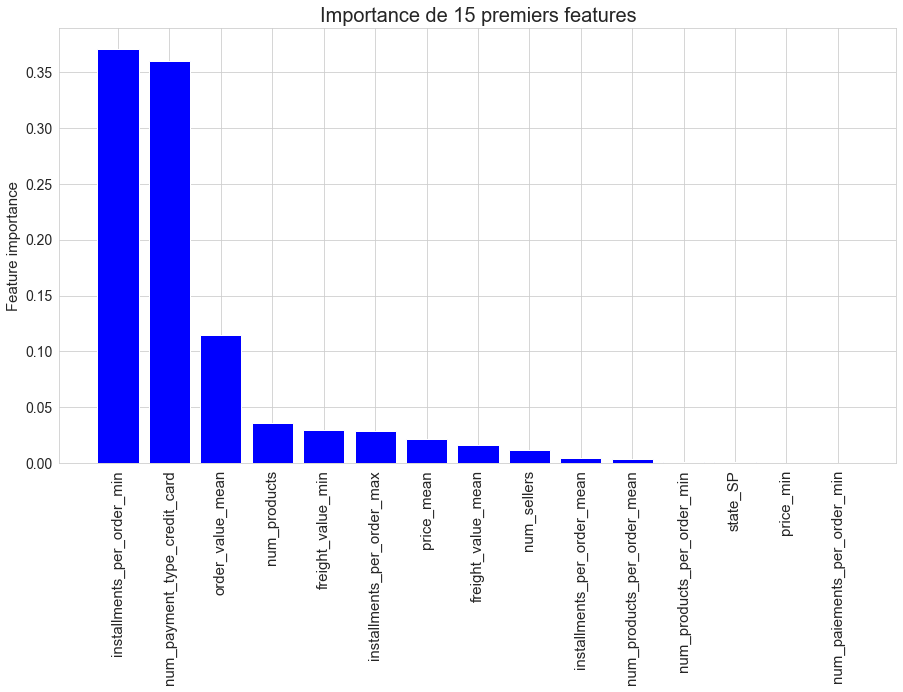

In [172]:
fig = plt.figure(figsize=(15, 8))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_ylabel('Feature importance', fontsize=15)
ax.set_title('Importance de 15 premiers features', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

# set height of bar
bars1 = feature_importances['Feature importance'][:15]

# Make the plot
plt.bar(range(15), bars1, color='blue', edgecolor='white')

# Add xticks on the middle of the group bars
plt.xticks(
    range(15), feature_importances.index[:15],  rotation=90, fontsize=15)

# Show graphic
plt.show()

Pour voir accuracy score :

In [173]:
y_pred_test = arbre.predict(X_test)

In [174]:
from sklearn.metrics import accuracy_score

In [175]:
accuracy_score(y_test, y_pred_test)

0.967966184587438

### 7.2.5 Description de clusters

In [176]:
data_analyses_kmeans = data_analyses.merge(
    y_pred, left_index=True, right_index=True)

In [177]:
data_analyses_kmeans.head()

,delay_last_order,delay_first_order,num_reviews_mean,review_score_mean_per_order,num_comment_title_mean,num_comment_message_mean,review_delay_min_days,review_delay_max_days,num_payment_type_credit_card,num_payment_type_voucher,...,num_products_per_order_mean,city_sup_1m,state_SP,state_RJ,state_MG,state_RS,state_PR,state_SC,state_BA,Cluster
861eff4711a542e4b93843c6dd7febb0,894,894,1.0,4.0,0.0,0.0,4,4,1.0,0.0,...,1.0,0,1,0,0,0,0,0,0,0
290c77bc529b7ac935b93aa66c333dc3,653,653,1.0,5.0,0.0,0.0,11,11,1.0,0.0,...,1.0,0,1,0,0,0,0,0,0,2
060e732b5b29e8181a18229c7b0b2b5e,526,526,1.0,5.0,0.0,0.0,0,0,1.0,0.0,...,1.0,1,1,0,0,0,0,0,0,0
259dac757896d24d7702b9acbbff3f3c,593,593,1.0,5.0,0.0,0.0,4,4,1.0,0.0,...,1.0,0,1,0,0,0,0,0,0,0
345ecd01c38d18a9036ed96c73b8d066,455,455,1.0,5.0,1.0,1.0,7,7,1.0,0.0,...,1.0,1,1,0,0,0,0,0,0,2


Test de Kruskal Wallis 

In [178]:
data0 = data_analyses_kmeans[data_analyses_kmeans['Cluster'] == 0]
data1 = data_analyses_kmeans[data_analyses_kmeans['Cluster'] == 1]
data2 = data_analyses_kmeans[data_analyses_kmeans['Cluster'] == 2]

In [179]:
def kruskal_test(*args):
    df = DataFrame(columns=['med_0', 'std_0', 'med_1',
                            'std_1', 'med_2', 'std_2', 't', 'p'])

    for var in args:

        med_0 = round(data0[var].describe().loc['50%'], 2)
        std_0 = round(data0[var].describe().loc['std'], 2)
        med_1 = round(data1[var].describe().loc['50%'], 2)
        std_1 = round(data1[var].describe().loc['std'], 2)
        med_2 = round(data2[var].describe().loc['50%'], 2)
        std_2 = round(data2[var].describe().loc['std'], 2)

        test = stats.kruskal(data0[var], data1[var], data2[var])

        t = round(test[0], 2)
        p = round(test[1], 6)

        ser = Series({'med_0': med_0, 'std_0': std_0, 'med_1': med_1,
                      'std_1': std_1, 'med_2': med_2, 'std_2': std_2, 't': t, 'p': p})
        ser.name = var
        df = df.append(ser)

    return df

In [180]:
data_analyses_kmeans.columns

Index(['delay_last_order', 'delay_first_order', 'num_reviews_mean',
       'review_score_mean_per_order', 'num_comment_title_mean',
       'num_comment_message_mean', 'review_delay_min_days',
       'review_delay_max_days', 'num_payment_type_credit_card',
       'num_payment_type_voucher', 'num_payment_type_boleto',
       'num_payment_type_debit_card', 'order_value_mean',
       'installments_per_order_mean', 'installments_per_order_min',
       'installments_per_order_max', 'num_paiements_per_order_mean',
       'num_paiements_per_order_min', 'num_paiements_per_order_max',
       'num_products_per_order_min', 'num_products_per_order_max',
       'num_products', 'num_sellers', 'price_min', 'price_max', 'price_mean',
       'freight_value_min', 'freight_value_max', 'freight_value_mean',
       'category_art_film_music', 'category_auto', 'category_baby',
       'category_books', 'category_electronics',
       'category_fashion_accessories', 'category_food_drinks',
       'category_healt

In [181]:
kruskal_test('delay_last_order', 'delay_first_order', 'num_reviews_mean',
             'review_score_mean_per_order', 'num_comment_title_mean',
             'num_comment_message_mean', 'review_delay_min_days',
             'review_delay_max_days', 'num_payment_type_credit_card',
             'num_payment_type_voucher', 'num_payment_type_boleto',
             'num_payment_type_debit_card', 'order_value_mean',
             'installments_per_order_mean', 'installments_per_order_min',
             'installments_per_order_max', 'num_paiements_per_order_mean',
             'num_paiements_per_order_min', 'num_paiements_per_order_max',
             'num_products_per_order_min', 'num_products_per_order_max',
             'num_products', 'num_sellers', 'price_min', 'price_max', 'price_mean',
             'freight_value_min', 'freight_value_max', 'freight_value_mean',
             'num_orders', 'payment_type_credit_card_mean',
             'payment_type_voucher_mean', 'payment_type_boleto_mean',
             'payment_type_debit_card_mean', 'num_products_per_order_mean')

C:\Users\Utilisateur\Anaconda3\lib\site-packages\scipy\stats\stats.py:5180: RuntimeWarning: overflow encountered in long_scalars
  h = 12.0 / (totaln * (totaln + 1)) * ssbn - 3 * (totaln + 1)


,med_0,std_0,med_1,std_1,med_2,std_2,t,p
delay_last_order,643.00,152.71,637.00,150.38,649.00,157.19,4.775425e+06,0.0
delay_first_order,644.00,152.86,660.00,153.35,650.00,157.46,4.776869e+06,0.0
num_reviews_mean,1.00,0.03,1.00,0.12,1.00,0.04,3.369033e+08,0.0
review_score_mean_per_order,5.00,1.28,4.00,1.57,5.00,1.39,5.962839e+06,0.0
num_comment_title_mean,0.00,0.32,0.00,0.34,0.00,0.34,1.506016e+07,0.0
num_comment_message_mean,0.00,0.49,0.50,0.50,0.00,0.50,6.509768e+06,0.0
review_delay_min_days,1.00,10.01,1.00,7.68,1.00,9.17,5.044031e+06,0.0
review_delay_max_days,1.00,10.04,1.00,9.64,1.00,9.18,5.034549e+06,0.0
num_payment_type_credit_card,1.00,0.46,2.00,1.28,1.00,0.30,7.502905e+06,0.0
num_payment_type_voucher,0.00,0.34,0.00,1.24,0.00,0.72,4.299392e+07,0.0


Choisir que les features intéressantes pour la présentation :

In [182]:
kruskal_test('delay_last_order',
             'review_score_mean_per_order',  'order_value_mean',
             'installments_per_order_mean',
             'num_products', 'price_mean',
             'num_products_per_order_mean')

,med_0,std_0,med_1,std_1,med_2,std_2,t,p
delay_last_order,643.00,152.71,637.00,150.38,649.00,157.19,4775424.84,0.0
review_score_mean_per_order,5.00,1.28,4.00,1.57,5.00,1.39,5962838.64,0.0
order_value_mean,85.58,73.20,159.12,260.04,278.71,427.36,5246440.55,0.0
installments_per_order_mean,1.00,1.49,3.00,2.94,8.00,3.05,5911804.92,0.0
num_products,1.00,0.17,2.00,1.24,1.00,0.18,15855673.30,0.0
price_mean,68.90,68.29,59.93,67.12,238.00,398.60,5165153.45,0.0
num_products_per_order_mean,1.00,0.14,2.00,1.14,1.00,0.15,18646983.59,0.0


Construction de graphique de pourcentage d'achat dans chaque catégorie de produits selon le cluster : 

In [183]:
def tableau_effectif(data, liste_categories, index):
    """Fonction qui a pour but de créer une table d'effectifs et de pourcentages 
    en reconstituant une variable catégorielle qui est exprimée comme matrice de variables binaires
    dans la table d'origine.

    Paramètres :

    - data : DataFrame d'origin
    - liste_categories : une liste de variables binaires à reconstituer dans une variable catégorielle
    - index : une liste contenant les noms de variables

    Sortie :

    - tableau : DataFrame avec l'effectif et pourcentage de la variable reconstituée classé par effectif. 
    L'index contient les noms de classes.

    """
    effectif = []
    for category in liste_categories:
        eff = sum(data[category])
        effectif.append(eff)

    pourc = []
    for category in liste_categories:
        pct = round(sum(data[category])*100/sum(effectif), 2)
        pourc.append(pct)

    tableau = {'Effectif': effectif, 'Pourcentage': pourc}
    tableau = DataFrame(tableau, index=index)
    tableau.sort_values('Effectif', ascending=False, inplace=True)

    return tableau

In [184]:
liste_categories = ['category_art_film_music', 'category_auto', 'category_baby',
       'category_books', 'category_electronics',
       'category_fashion_accessories', 'category_food_drinks',
       'category_health_beauty', 'category_home', 'category_office',
       'category_pet_shop', 'category_sports_leisure', 'category_tools',
       'category_toys']

In [185]:
index = ['Art, film, music', 'Auto', 'Baby',
       'Books', 'Electronics',
       'Fashion, accessories', 'Food, drinks',
       'Health, beauty', 'Home', 'Office',
       'Pet shop', 'Sports, leisure', 'Tools',
       'Toys']

In [186]:
category_cluster0 = tableau_effectif(data0, liste_categories, index)

In [187]:
category_cluster1 = tableau_effectif(data1, liste_categories, index)

In [188]:
category_cluster2 = tableau_effectif(data2, liste_categories, index)

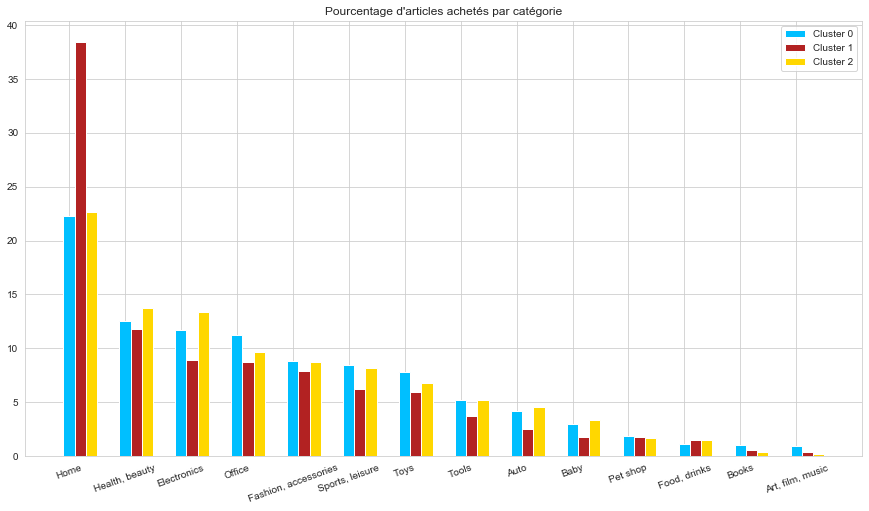

In [189]:
fig = plt.figure(figsize=(15, 8))

# set width of bar
barWidth = 0.2

# set height of bar
bars1 = category_cluster0['Pourcentage']
bars2 = category_cluster1['Pourcentage']
bars3 = category_cluster2['Pourcentage']

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, bars1, color='deepskyblue', width=barWidth,
        edgecolor='white', label='Cluster 0')
plt.bar(r2, bars2, color='firebrick', width=barWidth,
        edgecolor='white', label='Cluster 1')
plt.bar(r3, bars3, color='gold', width=barWidth,
        edgecolor='white', label='Cluster 2')

# Define title
plt.title("Pourcentage d'articles achetés par catégorie")

# Add xticks on the middle of the group bars
plt.xticks(range(category_cluster0.shape[0]),
           category_cluster0.index,  rotation=20)

# Create legend & Show graphic
plt.legend()
plt.show()

Pourcentage de clients en provenance d'une grande ville

In [190]:
# Cluster 0
round(sum(data0['city_sup_1m'])*100/data0.shape[0], 2)

36.27

In [191]:
# Cluster 1
round(sum(data1['city_sup_1m'])*100/data1.shape[0], 2)

38.43

In [192]:
# Cluster 2
round(sum(data2['city_sup_1m'])*100/data2.shape[0], 2)

30.01

Type de paiement

In [193]:
liste_categories = ['num_payment_type_credit_card', 'num_payment_type_voucher',
                    'num_payment_type_boleto', 'num_payment_type_debit_card']

index = ['Carte de crédit', 'Voucher', 'Boleto', 'Carte de débit']

In [194]:
category_cluster0 = tableau_effectif(data0, liste_categories, index)

In [195]:
category_cluster1 = tableau_effectif(data1, liste_categories, index)

In [196]:
category_cluster2 = tableau_effectif(data2, liste_categories, index)

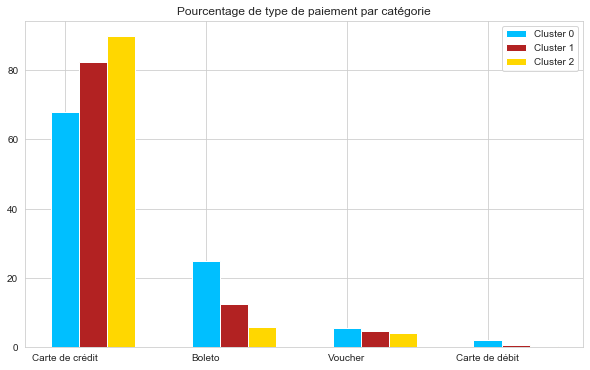

In [197]:
fig = plt.figure(figsize=(10, 6))

# set width of bar
barWidth = 0.2

# set height of bar
bars1 = category_cluster0['Pourcentage']
bars2 = category_cluster1['Pourcentage']
bars3 = category_cluster2['Pourcentage']

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, bars1, color='deepskyblue', width=barWidth,
        edgecolor='white', label='Cluster 0')
plt.bar(r2, bars2, color='firebrick', width=barWidth,
        edgecolor='white', label='Cluster 1')
plt.bar(r3, bars3, color='gold', width=barWidth,
        edgecolor='white', label='Cluster 2')

# Define title
plt.title("Pourcentage de type de paiement par catégorie")

# Add xticks on the middle of the group bars
plt.xticks(range(category_cluster0.shape[0]), category_cluster0.index)

# Create legend & Show graphic
plt.legend()
plt.show()

Etat 

In [198]:
liste_categories = ['state_SP', 'state_RJ',
                    'state_MG', 'state_RS', 'state_PR', 'state_SC', 'state_BA']

index = ['Sao Paulo', 'Rio de Janeiro', 'Minas Gerais', 'Rio Grande do Sul',
         'Parana', 'Santa Catarina', 'Bahia']

In [199]:
category_cluster0 = tableau_effectif(data0, liste_categories, index)

In [200]:
category_cluster1 = tableau_effectif(data1, liste_categories, index)

In [201]:
category_cluster2 = tableau_effectif(data2, liste_categories, index)

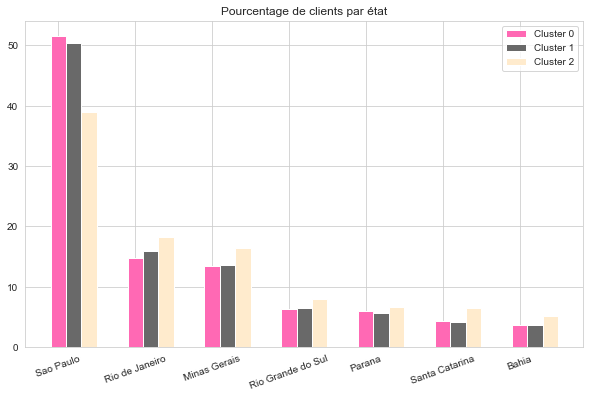

In [202]:
fig = plt.figure(figsize=(10, 6))

# set width of bar
barWidth = 0.2

# set height of bar
bars1 = category_cluster0['Pourcentage']
bars2 = category_cluster1['Pourcentage']
bars3 = category_cluster2['Pourcentage']

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, bars1, color='hotpink', width=barWidth,
        edgecolor='white', label='Cluster 0')
plt.bar(r2, bars2, color='dimgray', width=barWidth,
        edgecolor='white', label='Cluster 1')
plt.bar(r3, bars3, color='blanchedalmond', width=barWidth,
        edgecolor='white', label='Cluster 2')

# Define title
plt.title("Pourcentage de clients par état")

# Add xticks on the middle of the group bars
plt.xticks(range(category_cluster0.shape[0]),
           category_cluster0.index, rotation=20)

# Create legend & Show graphic
plt.legend()
plt.show()

### 7.2.6 Création de micro-segments

Nous allons créer des micro-segments pour chaque catégorie de k-means afin de pouvoir mieux définir les actions à prendre pour fidéliser ou re-motiver les clients :

In [203]:
RFM = data_RFM[['RFM_meilleur', 'RFM_nouveau', 'RFM_actif_valeur_elevee',
       'RFM_actif', 'RFM_warm_valeur_elevee', 'RFM_warm', 'RFM_a_reconquerir',
       'RFM_cold', 'RFM_presque_perdu']]

In [204]:
data_micro_segments = data_analyses_kmeans.merge(RFM, left_index=True, right_index=True)

In [205]:
data_micro_segments.head()

,delay_last_order,delay_first_order,num_reviews_mean,review_score_mean_per_order,num_comment_title_mean,num_comment_message_mean,review_delay_min_days,review_delay_max_days,num_payment_type_credit_card,num_payment_type_voucher,...,Cluster,RFM_meilleur,RFM_nouveau,RFM_actif_valeur_elevee,RFM_actif,RFM_warm_valeur_elevee,RFM_warm,RFM_a_reconquerir,RFM_cold,RFM_presque_perdu
861eff4711a542e4b93843c6dd7febb0,894,894,1.0,4.0,0.0,0.0,4,4,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
290c77bc529b7ac935b93aa66c333dc3,653,653,1.0,5.0,0.0,0.0,11,11,1.0,0.0,...,2,0,0,0,0,0,0,1,1,0
060e732b5b29e8181a18229c7b0b2b5e,526,526,1.0,5.0,0.0,0.0,0,0,1.0,0.0,...,0,0,1,1,1,0,0,0,0,0
259dac757896d24d7702b9acbbff3f3c,593,593,1.0,5.0,0.0,0.0,4,4,1.0,0.0,...,0,0,0,0,0,0,1,0,0,0
345ecd01c38d18a9036ed96c73b8d066,455,455,1.0,5.0,1.0,1.0,7,7,1.0,0.0,...,2,0,1,1,1,0,0,0,0,0


#### Microsegmentation de Cluster 0

In [206]:
# Macrocluster count
sum(data_micro_segments['Cluster'] == 0)

72489

In [207]:
# Creation of microcluster
data_micro_segments['ms_c0_valeur_elevee'] = np.where(((data_micro_segments['Cluster'] == 0) & ((
    data_micro_segments['RFM_actif_valeur_elevee'] == 1) | (data_micro_segments['RFM_warm_valeur_elevee'] == 1))), 1, 0)

In [208]:
# Count
sum(data_micro_segments['ms_c0_valeur_elevee'])

9544

In [209]:
# Percentage
round(sum(data_micro_segments['ms_c0_valeur_elevee'])
      * 100/sum(data_micro_segments['Cluster'] == 0), 2)

13.17

In [210]:
# Creation of microcluster
data_micro_segments['ms_c0_nouveau'] = np.where(((data_micro_segments['Cluster'] == 0) &
                                                 (data_micro_segments['RFM_nouveau'] == 1)), 1, 0)

In [211]:
# Count
sum(data_micro_segments['ms_c0_nouveau'])

17715

In [212]:
# Percentage
round(sum(data_micro_segments['ms_c0_nouveau'])
      * 100/sum(data_micro_segments['Cluster'] == 0), 2)

24.44

In [213]:
#Creation of microcluster
data_micro_segments['ms_c0_a_reconquerir'] = np.where(((data_micro_segments['Cluster'] == 0) & 
    (data_micro_segments['RFM_a_reconquerir']== 1)), 1, 0)

In [214]:
# Count
sum(data_micro_segments['ms_c0_a_reconquerir'])

5117

In [215]:
# Percentage
round(sum(data_micro_segments['ms_c0_a_reconquerir'])
      * 100/sum(data_micro_segments['Cluster'] == 0), 2)

7.06

#### Microsegmentation de Cluster 1

In [216]:
# Macrocluster count
sum(data_micro_segments['Cluster'] == 1)

9206

In [217]:
# Creation of microcluster
data_micro_segments['ms_c1_valeur_elevee'] = np.where(((data_micro_segments['Cluster'] == 1) & ((
    data_micro_segments['RFM_actif_valeur_elevee'] == 1) | (data_micro_segments['RFM_warm_valeur_elevee'] == 1))), 1, 0)

In [218]:
# Count
sum(data_micro_segments['ms_c1_valeur_elevee'])

2820

In [219]:
# Percentage
round(sum(data_micro_segments['ms_c1_valeur_elevee'])
      * 100/sum(data_micro_segments['Cluster'] == 1), 2)

30.63

In [220]:
# Creation of microcluster
data_micro_segments['ms_c1_nouveau'] = np.where(((data_micro_segments['Cluster'] == 1) &
                                                 (data_micro_segments['RFM_nouveau'] == 1)), 1, 0)

In [221]:
# Count
sum(data_micro_segments['ms_c1_nouveau'])

1811

In [222]:
# Percentage
round(sum(data_micro_segments['ms_c1_nouveau'])
      * 100/sum(data_micro_segments['Cluster'] == 1), 2)

19.67

In [223]:
# Creation of microcluster
data_micro_segments['ms_c1_a_reconquerir'] = np.where(((data_micro_segments['Cluster'] == 1) &
                                                       (data_micro_segments['RFM_a_reconquerir'] == 1)), 1, 0)

In [224]:
# Count
sum(data_micro_segments['ms_c1_a_reconquerir'])

2529

In [225]:
# Percentage
round(sum(data_micro_segments['ms_c1_a_reconquerir'])
      * 100/sum(data_micro_segments['Cluster'] == 1), 2)

27.47

#### Microsegmentation de Cluster 2

In [226]:
# Macrocluster count
sum(data_micro_segments['Cluster'] == 2)

13724

In [227]:
# Creation of microcluster
data_micro_segments['ms_c2_valeur_elevee'] = np.where(((data_micro_segments['Cluster'] == 2) & ((
    data_micro_segments['RFM_actif_valeur_elevee'] == 1) | (data_micro_segments['RFM_warm_valeur_elevee'] == 1))), 1, 0)

In [228]:
# Count
sum(data_micro_segments['ms_c2_valeur_elevee'])

5809

In [229]:
# Percentage
round(sum(data_micro_segments['ms_c2_valeur_elevee'])
      * 100 / sum(data_micro_segments['Cluster'] == 2), 2)

42.33

In [230]:
# Creation of microcluster
data_micro_segments['ms_c2_nouveau'] = np.where(((data_micro_segments['Cluster'] == 2) &
                                                 (data_micro_segments['RFM_nouveau'] == 1)), 1, 0)

In [231]:
# Count
sum(data_micro_segments['ms_c2_nouveau'])

3527

In [232]:
# Percentage
round(sum(data_micro_segments['ms_c2_nouveau'])
      * 100/sum(data_micro_segments['Cluster'] == 2), 2)

25.7

In [233]:
# Creation of microcluster
data_micro_segments['ms_c2_a_reconquerir'] = np.where(((data_micro_segments['Cluster'] == 2) &
                                                       (data_micro_segments['RFM_a_reconquerir'] == 1)), 1, 0)

In [234]:
# Count
sum(data_micro_segments['ms_c2_a_reconquerir'])

5129

In [235]:
# Percentage
round(sum(data_micro_segments['ms_c2_a_reconquerir'])
      * 100/sum(data_micro_segments['Cluster'] == 2), 2)

37.37

## 7.3 DBSCAN

### 7.3.1 La meilleure solution avec une recherche "manuelle" 

L'avantage de DBSCAN est que nous ne sommes pas obligées de définir à l'avance le nombre de clusters. En même temps, l'algorithme n'est pas exigeant au niveau de calcul et marche bien sur les gros jeux de données.


In [236]:
dbscan = DBSCAN(eps=5, min_samples=10)

In [237]:
dbscan.fit(principalDf)

DBSCAN(algorithm='auto', eps=5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

In [238]:
labels = Series(dbscan.labels_)

In [239]:
labels.value_counts()

 0    9510
-1      31
dtype: int64

In [240]:
labels.nunique()

2

Après avoir relancé l'algorithme plusieurs fois avec des paramètres différents, nous avons trouvé la meilleure solution avec les paramètres epsilon = 5 et min_samples = 10. Par contre, le nombre de clusters ainsi créé est égale à 42, ce qui n'est pas optimal de point de vu commercial. Nous allons essayer de rechercehr les meilleurs paramètres avec une recherche sur grille en imposant le nombre de clusters entre 2 et 6, ce qui est beaucoup plus pratique pour interprétation de la segmentation.

### 7.3.2 Recherche de paramètres sur grille

Nous allons chercher à optimiser la méthode DBSCAN en utilisant différents paramètres epsilon (eps) et min_samples afin d'obtenir un nombre raisonnable et interprétable de clusters. Afin d'automatiser la recherche, nous allons utiliser une fonction qui performe une recherche en grille :

In [241]:
def dbscan_grid_search(X_data, lst, clst_count, eps_space=0.5,
                       min_samples_space=5, min_clust=0, max_clust=10):
    """
Performs a hyperparameter grid search for DBSCAN.

Parameters:
    * X_data            = data used to fit the DBSCAN instance
    * lst               = a list to store the results of the grid search
    * clst_count        = a list to store the number of non-whitespace clusters
    * eps_space         = the range values for the eps parameter
    * min_samples_space = the range values for the min_samples parameter
    * min_clust         = the minimum number of clusters required after each search iteration in order for a result to be appended to the lst
    * max_clust         = the maximum number of clusters required after each search iteration in order for a result to be appended to the lst


Example:

# Loading Libraries
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Loading iris dataset
iris = datasets.load_iris()
X = iris.data[:, :] 
y = iris.target

# Scaling X data
dbscan_scaler = StandardScaler()

dbscan_scaler.fit(X)

dbscan_X_scaled = dbscan_scaler.transform(X)

# Setting empty lists in global environment
dbscan_clusters = []
cluster_count   = []


# Inputting function parameters
dbscan_grid_search(X_data = dbscan_X_scaled,
                   lst = dbscan_clusters,
                   clst_count = cluster_count
                   eps_space = pd.np.arange(0.1, 5, 0.1),
                   min_samples_space = pd.np.arange(1, 50, 1),
                   min_clust = 3,
                   max_clust = 6)

"""

    # Importing counter to count the amount of data in each cluster
    from collections import Counter

    # Starting a tally of total iterations
    n_iterations = 0

    # Looping over each combination of hyperparameters
    for eps_val in eps_space:
        for samples_val in min_samples_space:

            dbscan_grid = DBSCAN(eps=eps_val,
                                 min_samples=samples_val)

            # fit_transform
            clusters = dbscan_grid.fit_predict(X=X_data)

            # Counting the amount of data in each cluster
            cluster_count = Counter(clusters)

            # Saving the number of clusters
            n_clusters = sum(abs(pd.np.unique(clusters))) - 1

            # Increasing the iteration tally with each run of the loop
            n_iterations += 1

            # Appending the lst each time n_clusters criteria is reached
            if n_clusters >= min_clust and n_clusters <= max_clust:

                dbscan_clusters.append([eps_val,
                                        samples_val,
                                        n_clusters])

                clst_count.append(cluster_count)

    # Printing grid search summary information
    print(f"""Search Complete. \nYour list is now of length {len(lst)}. """)
    print(f"""Hyperparameter combinations checked: {n_iterations}. \n""")

Afin d'optimiser le temps de calcul, la recherche sur grille va être performée sur l'échantillon.

In [242]:
dbscan_clusters = []
cluster_count = []

In [243]:
dbscan_grid_search(X_data=data_ACP_30CP_sample,
                   lst=dbscan_clusters,
                   clst_count=cluster_count,
                   eps_space=pd.np.arange(0.1, 5, 0.5),
                   min_samples_space=pd.np.arange(5, 50, 5),
                   min_clust=2,
                   max_clust=6)

Search Complete. 
Your list is now of length 3. 
Hyperparameter combinations checked: 90. 



In [244]:
dbscan_clusters

[[1.1, 25, 3], [1.6, 40, 6], [1.6, 45, 3]]

In [245]:
cluster_count

[Counter({-1: 9422, 0: 34, 1: 29, 2: 56}),
 Counter({-1: 9020, 0: 100, 1: 229, 2: 87, 3: 105}),
 Counter({-1: 9136, 0: 96, 1: 217, 2: 92})]

Conclusion : Comme l'on peut voir, la majorité de points est classée comme outlier (cluster -1). Les clusters ne sont pas assez homogènes pour permettre à DBSCAN de trouver les segments. Nous avons atteint meilleurs résultats avec l'algorithme k-means.

# 8 - Evaluation de la fréquence de mise à jour

Afin d'évaluer la fréquence de mise à jour nécessaire pour maitenir la stabilité de clusters, nous allons étudier les données d'une manière chronologique. La procédure la plus juste consisterais à étudier les commandes dans l'ordre qu'elles arrivent. Par contre, cette procédure nous obligerais de refaire les pipelines de fusion des tables et de data engineering. 

Pour le but de ce projet, nous allons partir d'un princip simplifié : Nous allons prendre uniquement la dernière commande de chaque client. Il s'agit bien d'une approximation pour éviter une procédure très chronologique.

Nous disposons de 24 mois de données. Dans un premier temps, nous allons créer des données de baseline qui contient les commandes effectuées les 12 mois premiers mois. Ensuite, nous allons injecter les nouveaux données  dans le modèle tous les mois et recalculer l'indice de Rand ajusté sur les données de baseline.   

Dans un premier temps, nous allons créer une variable pour classer les clients par mois d'achat.

In [246]:
max(data_analyses['delay_last_order'])

1148

In [247]:
min(data_analyses['delay_last_order'])

419

In [248]:
i = list(range(25))

In [249]:
bins = [416+elt*30 for elt in i]

In [250]:
len(bins)

25

In [251]:
labels = []
for i in range(24):
    lab = 'month_'+str(i)
    labels.append(lab)

In [252]:
labels.reverse()

In [253]:
month_last_order = pd.cut(
    data_analyses["delay_last_order"], bins=bins, labels=labels)

In [254]:
month_last_order.value_counts()

month_14    8032
month_19    7220
month_17    6992
month_16    6932
month_22    6787
month_18    6612
month_21    5924
month_20    5888
month_15    4954
month_23    4570
month_13    4244
month_12    4239
month_10    3870
month_11    3797
month_8     3403
month_9     3101
month_7     2709
month_6     2342
month_5     1943
month_4     1483
month_0      296
month_3       79
month_1        0
month_2        0
Name: delay_last_order, dtype: int64

In [255]:
data_frequence = data_ACP_30CP.merge(
    month_last_order, left_index=True, right_index=True)

In [256]:
data_frequence.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,delay_last_order
861eff4711a542e4b93843c6dd7febb0,-0.393204,-0.403101,-0.126299,-0.334207,-1.645600,0.190624,0.333809,-0.294729,-0.596775,1.271320,...,-0.107527,-0.070205,-0.042996,0.273371,-0.459559,-0.027521,0.210837,0.325895,-0.261162,month_8
290c77bc529b7ac935b93aa66c333dc3,3.677567,-1.725261,-0.362475,-0.836104,-0.279764,-0.681794,0.921672,0.486310,0.110868,-1.083140,...,0.149668,-0.171277,-0.062598,-0.023738,-0.120593,-0.345470,0.031757,0.116073,0.090446,month_16
060e732b5b29e8181a18229c7b0b2b5e,0.947733,-0.456169,-0.159573,-1.748498,0.761240,0.869725,-0.712773,0.566096,0.036314,-1.117965,...,0.570140,-0.190588,0.012032,0.078698,-0.200007,-0.073003,0.157231,-0.041417,-0.309677,month_20
259dac757896d24d7702b9acbbff3f3c,-0.521711,-0.572137,-0.245993,0.147178,0.635921,0.070673,0.001478,0.512720,-0.056556,1.520403,...,-0.030213,-0.161076,-0.144356,0.122362,-0.409260,-0.138275,0.217468,0.049651,-0.373291,month_18
345ecd01c38d18a9036ed96c73b8d066,2.207662,-0.746979,-0.281909,-1.676835,2.273367,0.637202,-0.027306,1.775726,0.949444,-2.304092,...,0.396271,-0.258398,-0.274627,0.083698,-0.077730,-0.170799,-0.088773,0.002637,-0.282857,month_22


Création de données de baseline :

In [257]:
liste_baseline = []
for i in range(12):
    elt = 'month_' + str(i)
    liste_baseline.append(elt)

In [258]:
liste_baseline

['month_0',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11']

In [259]:
data_baseline = data_frequence[data_frequence['delay_last_order'].isin(
    liste_baseline)]

In [260]:
data_baseline.shape

(23023, 31)

In [261]:
data_baseline.drop(['delay_last_order'], axis=1, inplace=True)

kmeans = KMeans(n_clusters=3, random_state=23)

C:\Users\Utilisateur\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [262]:
y_pred = kmeans.fit_predict(data_baseline)

In [263]:
y_pred = DataFrame(y_pred, index=data_baseline.index)

In [264]:
y_pred.rename({0: 'cluster_baseline'}, axis=1, inplace=True)

In [265]:
silhouette_score(data_baseline, kmeans.labels_)

0.21697903019977235

In [266]:
data_baseline = data_baseline.merge(y_pred, left_index=True, right_index=True)

In [267]:
data_baseline['cluster_baseline'].value_counts()

0    17951
1     5024
2       48
Name: cluster_baseline, dtype: int64

Nous avons créé les clusters de baseline. Maintenant nous allons injecter les données mois après mois et recalculer les clusters. Afin de faire ceci, nous allons utiliser la fonction suivante: 

In [268]:
labels

['month_23',
 'month_22',
 'month_21',
 'month_20',
 'month_19',
 'month_18',
 'month_17',
 'month_16',
 'month_15',
 'month_14',
 'month_13',
 'month_12',
 'month_11',
 'month_10',
 'month_9',
 'month_8',
 'month_7',
 'month_6',
 'month_5',
 'month_4',
 'month_3',
 'month_2',
 'month_1',
 'month_0']

In [269]:
labels.reverse()

In [270]:
list(range(12, len(labels)))

[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

In [271]:
labels[:12]

['month_0',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'month_7',
 'month_8',
 'month_9',
 'month_10',
 'month_11']

In [272]:
def calcul_rand(data_baseline, labels):
    """Fonction qui prend un DataFrame de baseline contenant les clusters créé initialement 
    et qui retourne une liste avec l'indice de Rand pour chaque nouveau clustering créé 
    avec des données injectées par mois.

    Paramétres : 

    - data_baseline : DataFrame contenant les id de clients en index et la variable 'cluster_baseline'
    avec le résultat de clustering initial

    - labels : une liste de classes qui caractérisent le mois de la dernière commande

    Sortie : Une liste avec les indices de rand pour chaque nouvelle segmentation

    """

    liste_rand = []

    kmeans = KMeans(n_clusters=3, random_state=27)

    for i in range(13, len(labels)+1):

        data = data_frequence[data_frequence['delay_last_order'].isin(
            labels[:i])]
        data.drop(['delay_last_order'], axis=1, inplace=True)

        y_pred = kmeans.fit_predict(data)

        y_pred = DataFrame(y_pred, index=data.index)

        name = 'cluster_new' + str(i)

        y_pred.rename({0: name}, axis=1, inplace=True)

        data_temp = data_baseline.merge(
            y_pred, left_index=True, right_index=True)

        ARI = adjusted_rand_score(
            data_temp['cluster_baseline'], data_temp[name])

        liste_rand.append(ARI)

    return liste_rand

In [273]:
liste_ARI = calcul_rand(data_baseline, labels)

C:\Users\Utilisateur\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: Set

In [274]:
liste_ARI

[0.9724489708611493,
 0.9509528401550963,
 0.935760201139326,
 0.9473177730536002,
 0.9333139323556024,
 0.9182688439919182,
 0.9142290793562752,
 0.9063256827645426,
 0.7644160973405872,
 0.7593668211792592,
 0.7230624153021457,
 0.7451745750947422]

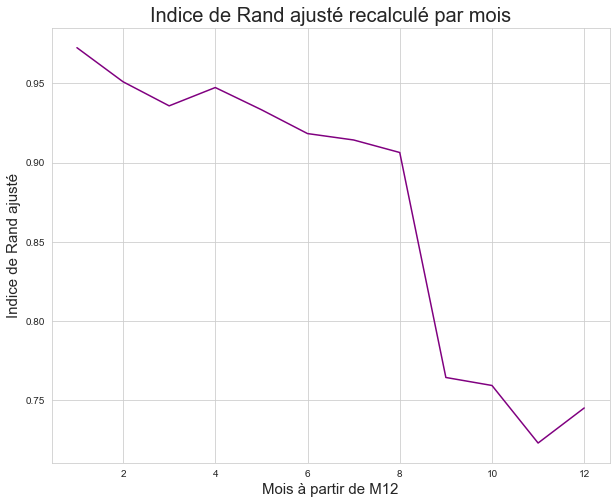

In [275]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Mois à partir de M12', fontsize=15)
ax.set_ylabel('Indice de Rand ajusté', fontsize=15)
ax.set_title('Indice de Rand ajusté recalculé par mois', fontsize=20)

plt.plot(range(1,13), liste_ARI, color="purple")

L'indice de Rand devient instable avec une tendance à diminuer à partir de M8. La maintenance est donc recommandée au moins tous les 8 mois. Dans l'idéal, nous pouvons établir un contrat de maintenance bi-annuel. 